# 1. Defining the Question(s)

1.2 Primary Question: To what extent do defensive matchup assignments and spatial positioning (shot distance and location) predict the probability of a shot being made for high-usage players during the 2021 NBA Playoffs?

1.3 Supporting Questions

    Defender Effect: Is there a statistically significant difference in field goal probability when a shooter is guarded by specific defenders (Trae Young vs. Russell Westbrook, etc), controlling for shot location?

    Spatial Dynamics: Does shot probability decay linearly with distance bands (RANGE), or do continuous spatial coordinates (X,Y) provide a better fit for predicting outcomes?

    Player-Specific Patterns: Do the relationships between defensive pressure and shot success remain stable across different offensive playstyles (e.g., Seth Curry vs. Russell Westbrook)?

    Predictive Validity: Can a logistic regression model utilizing these spatial and context features achieve predictive power better than random chance (AUC > 0.5)?

# 2. Data Collection
For this project, we use the NBA Shooting Data dataset available through DataCamp (https://www.datacamp.com/datalab/datasets/dataset-python-nba-shooting-data). We selected this specific dataset because it provides structured shot-level information appropriate for resampling and predictive modeling. The dataset contains shot-by-shot outcomes for four players during the 2021 NBA Playoffs, and the unit of observation is a single shot attempt, meaning each row represents one recorded playoff shot taken by one of the selected players. Because this is a curated and intentionally narrow dataset, the population of interest is best defined as all shot attempts taken by the four selected players during the 2021 NBA Playoffs. As a result, our conclusions are framed around these players and this postseason context rather than generalized to the entire NBA or multiple seasons. This scope is appropriate for our objective of identifying player-specific patterns tied to shot distance and defender assignment using the data available.

Key Variables

SHOOTER (string, categorical): Name of the player taking the shot

X (float, numeric): Horizontal distance from the basket in feet

Y (float, numeric): Vertical distance from the basket in feet

RANGE (string, categorical/ordinal): Shot distance band from the basket in feet

DEFENDER (string, categorical): Name of the nearest or primary defender on the shot

SCORE (string, binary categorical): Shot result recorded as MADE or MISSED

This dataset includes spatial shot location, defensive context, and binary outcome labels, allowing us to analyze shooting efficiency by location and explore whether matchup context is associated with differences in success rates. The X and Y coordinates provide continuous spatial information in feet relative to the basket, while RANGE offers discretized distance categories that support grouped comparisons across shot types and zones. Although the dataset documentation does not provide full technical detail about upstream extraction beyond describing it as playoff shooting data for these four players, we treat the dataset as a reliable, curated sample designed to support reproducible analysis, resampling-based inference, and modeling. Because the dataset is limited to four players, we anticipate an imbalance in shot counts across shooters, ranges, and defenders. Some defenders may appear only a few times, which can lead to unstable estimates if analyzed at too granular a level. For this reason, defender-related analyses may require thresholding, grouping rare categories, or careful interpretation of uncertainty, especially in bootstrap confidence intervals and logistic regression models. Additionally, since RANGE depends on predefined binning rules, our interpretations involving distance bands will confirm that these groupings meaningfully align with our research question.

# Data cleaning/prep: 
We first inspected all variables (SHOOTER, X, Y, RANGE, DEFENDER, SCORE) and found no missing values, inconsistent labels, or obvious outliers, so no rows required correction, imputation, or removal. For modeling, we standardized the numeric location features (X and Y) using a standard scaler. In addition, we created a new field goal percentage column by computing made shots divided by total shots for each player based on the SCORE column, which we used for player-level descriptive comparisons.

## Data Dictionary
|variable |class     |description                                                  |
|:--------|:---------|:------------------------------------------------------------|
|SHOOTER  |String    |Name of the player taking the shot                           |
|X        |float     |Horizontal distance of the shot taken from the basket in ft  |
|Y        |float     |Vertical distance of the shot taken from the basket in ft    |
|RANGE    |String    |Radius range of the shot taken from the basket in ft         |
|DEFENDER |String    |Name of the player defending the shot                        |
|SCORE    |String    |'MADE' if shot is scored, else 'MISSED'                      |

In [2]:
import pandas as pd
nba = pd.read_csv("nba_players_shooting.csv", index_col=0)
print(nba.shape)
nba.head(776)


(776, 6)


,SHOOTER,X,Y,RANGE,DEFENDER,SCORE
INDEX,,,,,,
0,Seth Curry,-3.808987,5.583621,"(0, 4)",Chris Paul,MADE
1,Seth Curry,-0.104279,5.919138,"(0, 4)",Trae Young,MADE
2,Seth Curry,-0.525864,8.912239,"(0, 4)",Trae Young,MADE
3,Seth Curry,-0.790616,7.503782,"(0, 4)",Chris Paul,MADE
4,Seth Curry,2.119074,5.320534,"(0, 4)",Trae Young,MADE
...,...,...,...,...,...,...
771,Trae Young,23.952742,15.324875,"(25, 29)",Russell Westbrook,MISSED
772,Trae Young,6.221766,30.756008,"(25, 29)",Seth Curry,MISSED
773,Trae Young,16.397467,27.660323,"(25, 29)",Chris Paul,MISSED


# 3 Analytical Approach
To answer the research question, five exploratory avenues were employed:

- Field Goal Percentage (FG%) by Range and by Defender – to identify general trends in shooting efficiency.
- Scatter Plots of X and Y Coordinates – to visualize spatial shot tendencies and success for each player.
- FG% by Player and Range (Bar Graph) – to compare individual players’ efficiency across different distances.
- FG% vs. Shot Distance (Line Chart) – to analyze shooting efficiency continuously across distances and identify trends or anomalies.
- FG% vs. Defenders (Grouped Bar Chart) – to quantify performance differences in head-to-head matchups.

## Avenue 1: Average Field Goal% By Shooting Ranges and Defenders


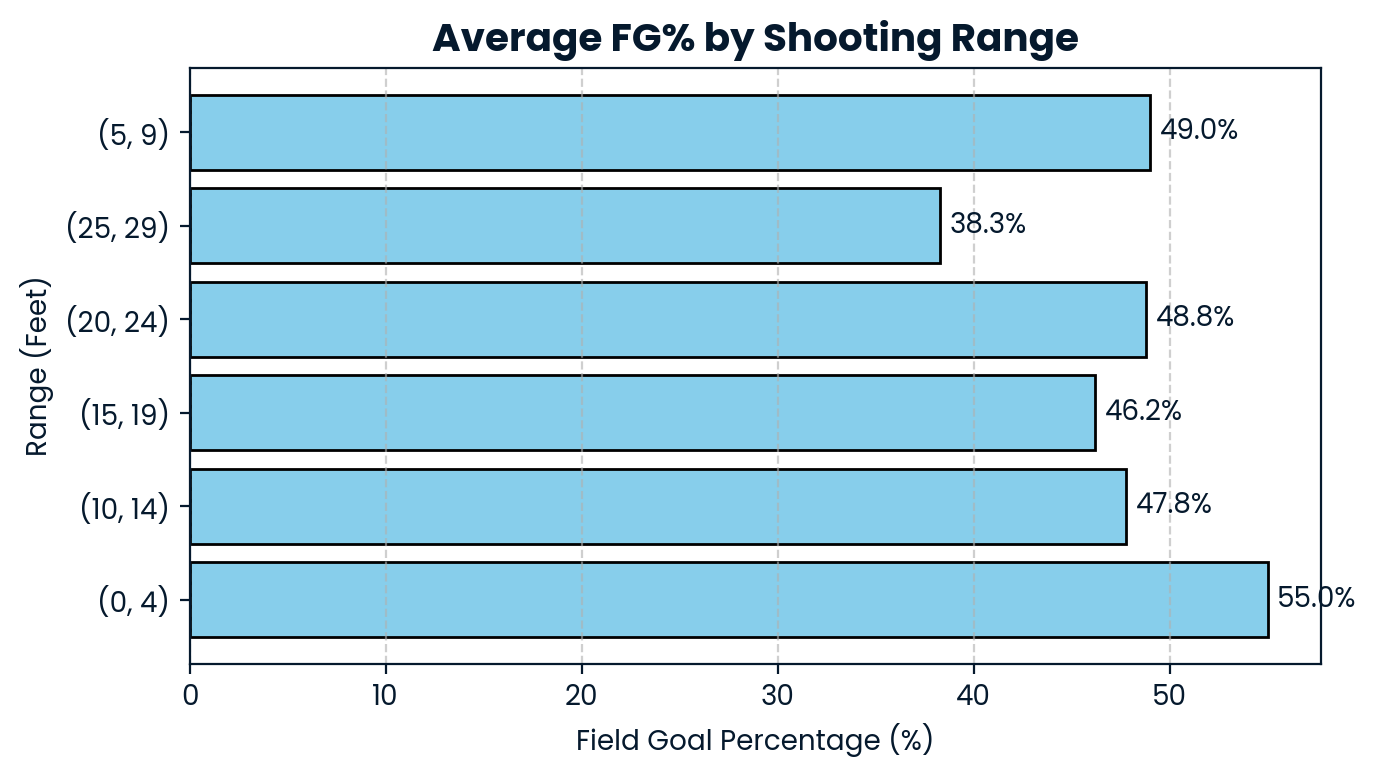

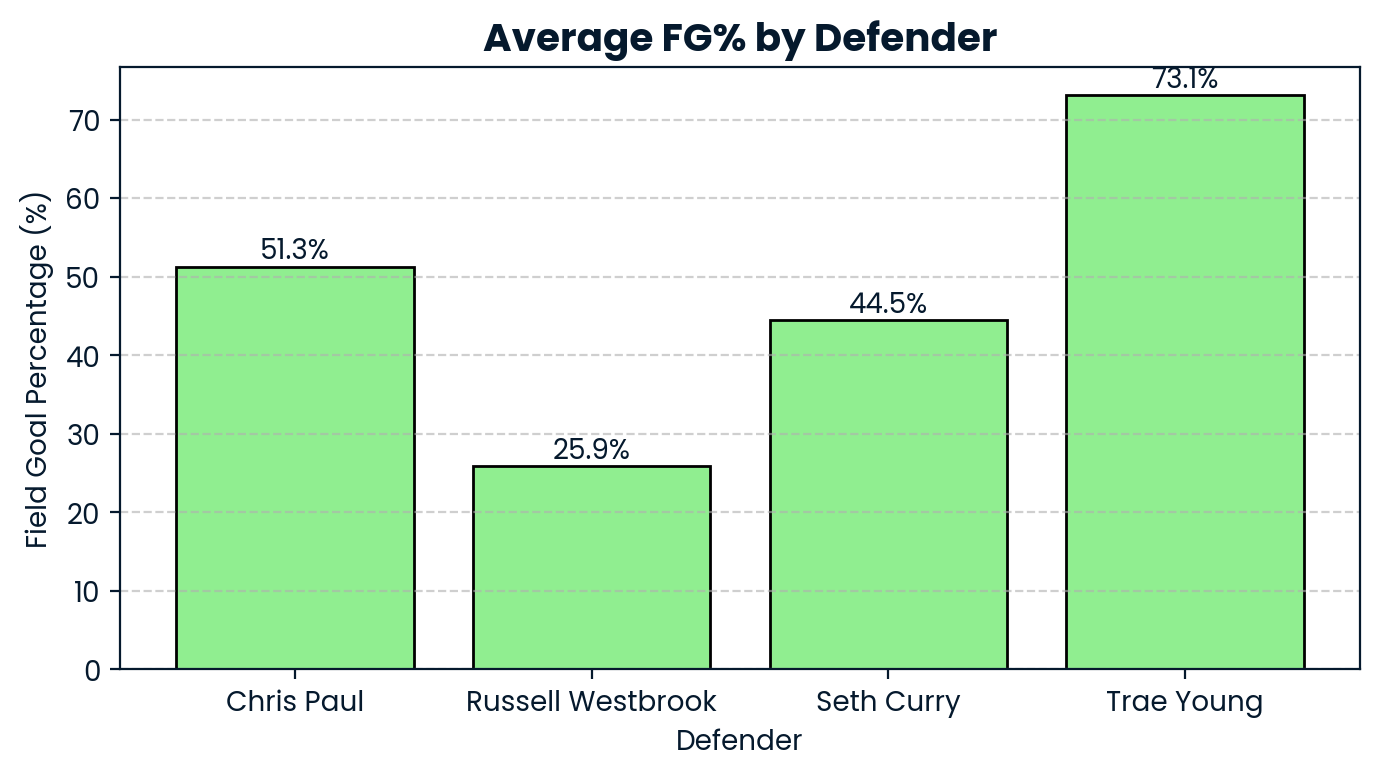

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Data Loading and Setup ---

try:
    nba = pd.read_csv("nba_players_shooting.csv", index_col=0)
except FileNotFoundError:
    print("Error: 'nba_players_shooting.csv' not found. Please ensure the data file is in the correct location.")
    exit()

# Convert MADE/MISSED to numerical flag
nba['MadeFlag'] = nba['SCORE'].apply(lambda x: 1 if x.upper() == 'MADE' else 0)


# --- 2. Mean FG% by Range (Bar Chart) ---

fg_by_range = nba.groupby('RANGE').agg(
    Mean_FG=('MadeFlag', 'mean'),
    Attempts=('MadeFlag', 'count')
).reset_index()
fg_by_range['Mean_FG_Display'] = (fg_by_range['Mean_FG'] * 100).round(1)

# Visualization Choice:
# → **Horizontal Bar Chart** — best for comparing FG% across categorical ranges clearly.
plt.figure(figsize=(7, 4))
bars = plt.barh(fg_by_range['RANGE'], fg_by_range['Mean_FG_Display'], color='skyblue', edgecolor='black')

# Add labels on bars
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.1f}%", va='center', fontsize=10)

plt.title("Average FG% by Shooting Range", fontsize=14, fontweight='bold')
plt.xlabel("Field Goal Percentage (%)")
plt.ylabel("Range (Feet)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# --- 3. Mean FG% by Defender (Vertical Bar Chart) ---

fg_by_defender = nba.groupby('DEFENDER').agg(
    Mean_FG=('MadeFlag', 'mean'),
    Attempts=('MadeFlag', 'count')
).reset_index()
fg_by_defender['Mean_FG_Display'] = (fg_by_defender['Mean_FG'] * 100).round(1)

# Visualization Choice:
# → **Vertical Bar Chart** — great for ranking defenders and highlighting who suppresses shooting most effectively.
plt.figure(figsize=(7, 4))
bars = plt.bar(fg_by_defender['DEFENDER'], fg_by_defender['Mean_FG_Display'],
               color='lightgreen', edgecolor='black')

# Add percentage labels on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f"{bar.get_height():.1f}%", ha='center', fontsize=10)

plt.title("Average FG% by Defender", fontsize=14, fontweight='bold')
plt.ylabel("Field Goal Percentage (%)")
plt.xlabel("Defender")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


This analysis examines how external circumstances, specifically shooting distance and the assigned defender, impact a player's field goal percentage (FG%). The dataset focuses on four NBA players: Chris Paul, Russell Westbrook, Seth Curry, and Trae Young during the 2021 Playoffs. Each visualization was selected to isolate and explain these factors, moving from high-level aggregate trends to player-specific comparisons. The first dashboard provides an aggregate view of shooting performance by range and defender. The average FG% by shooting range shows that shots taken within 4 feet of the basket are the most effective (55.0%), reflecting layups and dunks, while shots from the 25–29 foot range are the least effective (38.3%), representing long three-pointers. Mid-range shots (10–24 feet) maintain a relatively consistent efficiency between 46–48%. The average FG% by defender illustrates how players perform under different defensive pressure: players guarded by Russell Westbrook struggled the most, shooting 25.9% on average, whereas those defended by Trae Young were the most successful at 73.1%. Bar charts were chosen as the visualization type because they allow for easy comparison of a quantitative metric (FG%) across discrete categories. Horizontal bars were used for the range chart to accommodate longer categorical labels, while vertical bars were used for the defender chart for intuitive reading of player names. Distinct colors such as light blue for range and light green for defender were applied to visually separate the two analyses, reinforcing that they represent related but distinct dimensions of shooting performance.

## Avenue 2: Spatial Shot Distribution

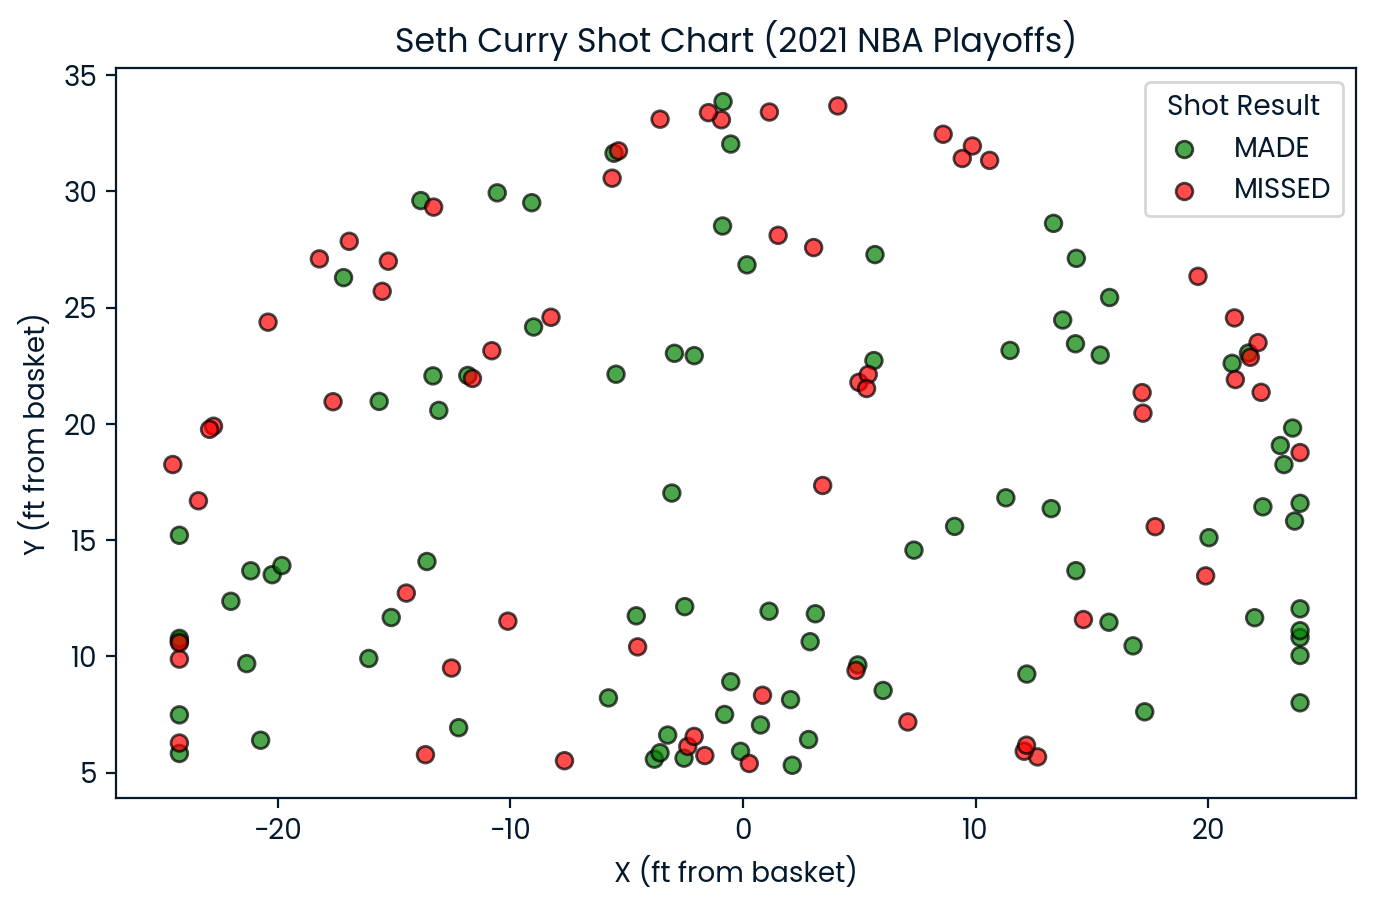

In [4]:
import matplotlib.pyplot as plt

# Filter data for Seth Curry
seth_curry_shots = nba[nba['SHOOTER'] == 'Seth Curry']

# Set color map for 'MADE' and 'MISSED'
color_map = {'MADE': 'green', 'MISSED': 'red'}
colors = seth_curry_shots['SCORE'].map(color_map)

plt.figure(figsize=(8, 7))
plt.scatter(seth_curry_shots['X'], seth_curry_shots['Y'], c=colors, alpha=0.7, edgecolor='k')

# Add legend
for score, color in color_map.items():
    plt.scatter([], [], c=color, label=score, alpha=0.7, edgecolor='k')
plt.legend(title='Shot Result')

plt.title("Seth Curry Shot Chart (2021 NBA Playoffs)")
plt.xlabel("X (ft from basket)")
plt.ylabel("Y (ft from basket)")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

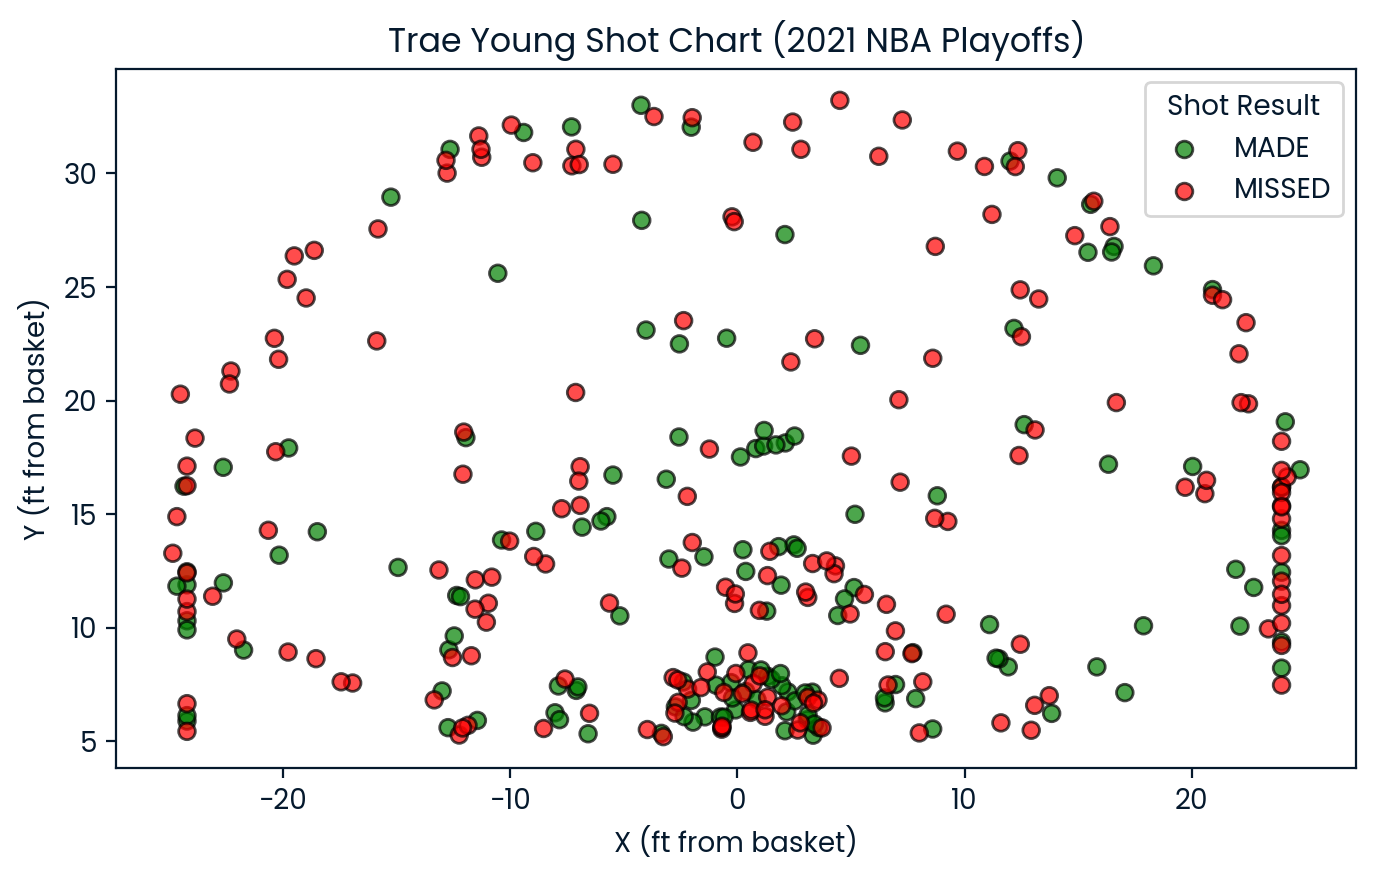

In [5]:
import matplotlib.pyplot as plt

# Filter data for Seth Curry
trae_young_shots = nba[nba['SHOOTER'] == 'Trae Young']

# Set color map for 'MADE' and 'MISSED'
color_map = {'MADE': 'green', 'MISSED': 'red'}
colors = trae_young_shots['SCORE'].map(color_map)

plt.figure(figsize=(8, 7))
plt.scatter(trae_young_shots['X'], trae_young_shots['Y'], c=colors, alpha=0.7, edgecolor='k')

# Add legend
for score, color in color_map.items():
    plt.scatter([], [], c=color, label=score, alpha=0.7, edgecolor='k')
plt.legend(title='Shot Result')

plt.title("Trae Young Shot Chart (2021 NBA Playoffs)")
plt.xlabel("X (ft from basket)")
plt.ylabel("Y (ft from basket)")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

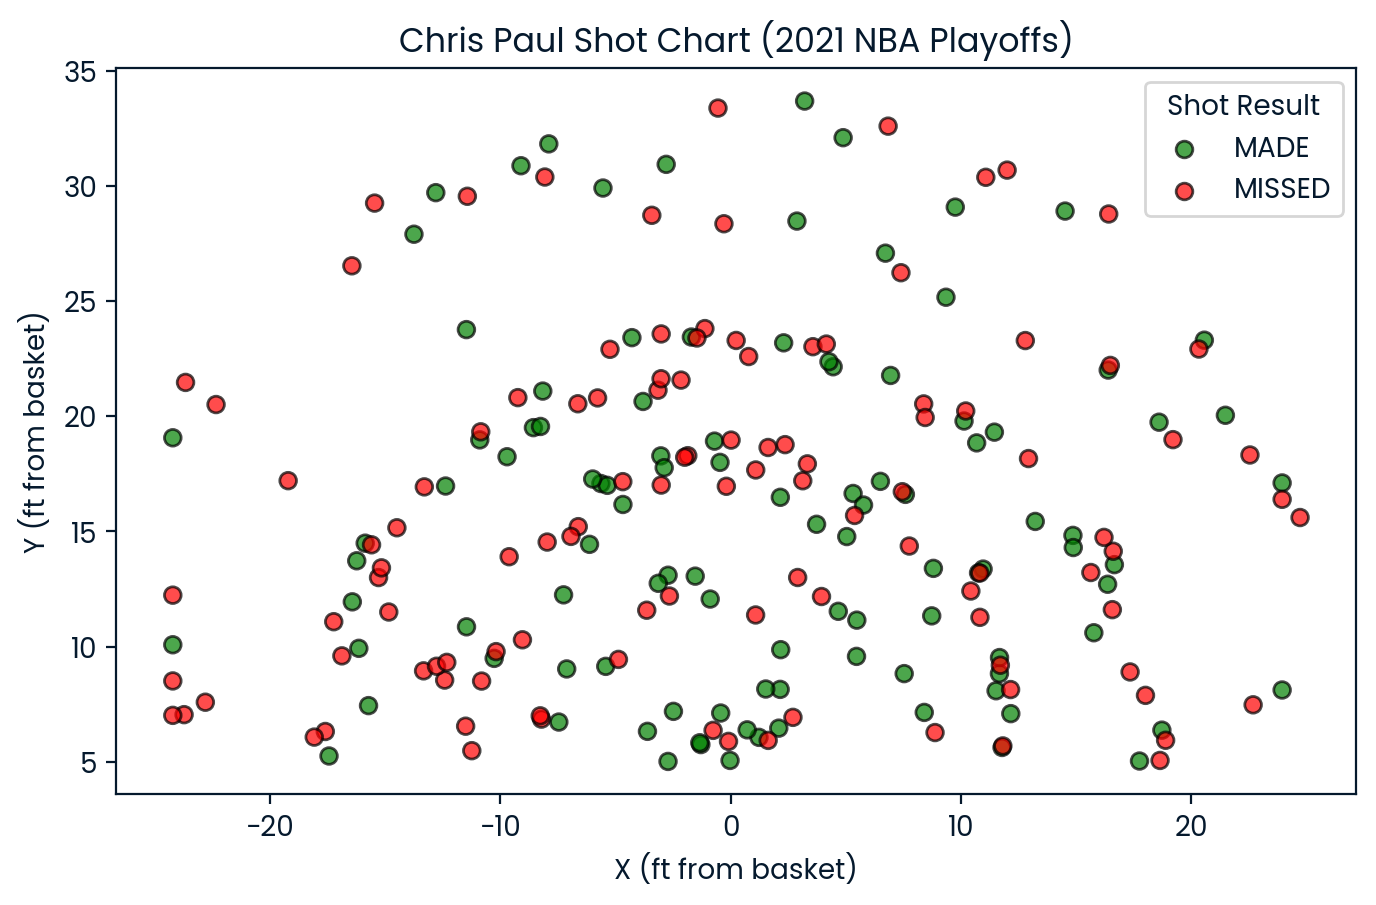

In [6]:
import matplotlib.pyplot as plt

# Filter data for Seth Curry
chris_paul_shots = nba[nba['SHOOTER'] == 'Chris Paul']

# Set color map for 'MADE' and 'MISSED'
color_map = {'MADE': 'green', 'MISSED': 'red'}
colors = chris_paul_shots['SCORE'].map(color_map)

plt.figure(figsize=(8, 7))
plt.scatter(chris_paul_shots['X'], chris_paul_shots['Y'], c=colors, alpha=0.7, edgecolor='k')

# Add legend
for score, color in color_map.items():
    plt.scatter([], [], c=color, label=score, alpha=0.7, edgecolor='k')
plt.legend(title='Shot Result')

plt.title("Chris Paul Shot Chart (2021 NBA Playoffs)")
plt.xlabel("X (ft from basket)")
plt.ylabel("Y (ft from basket)")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

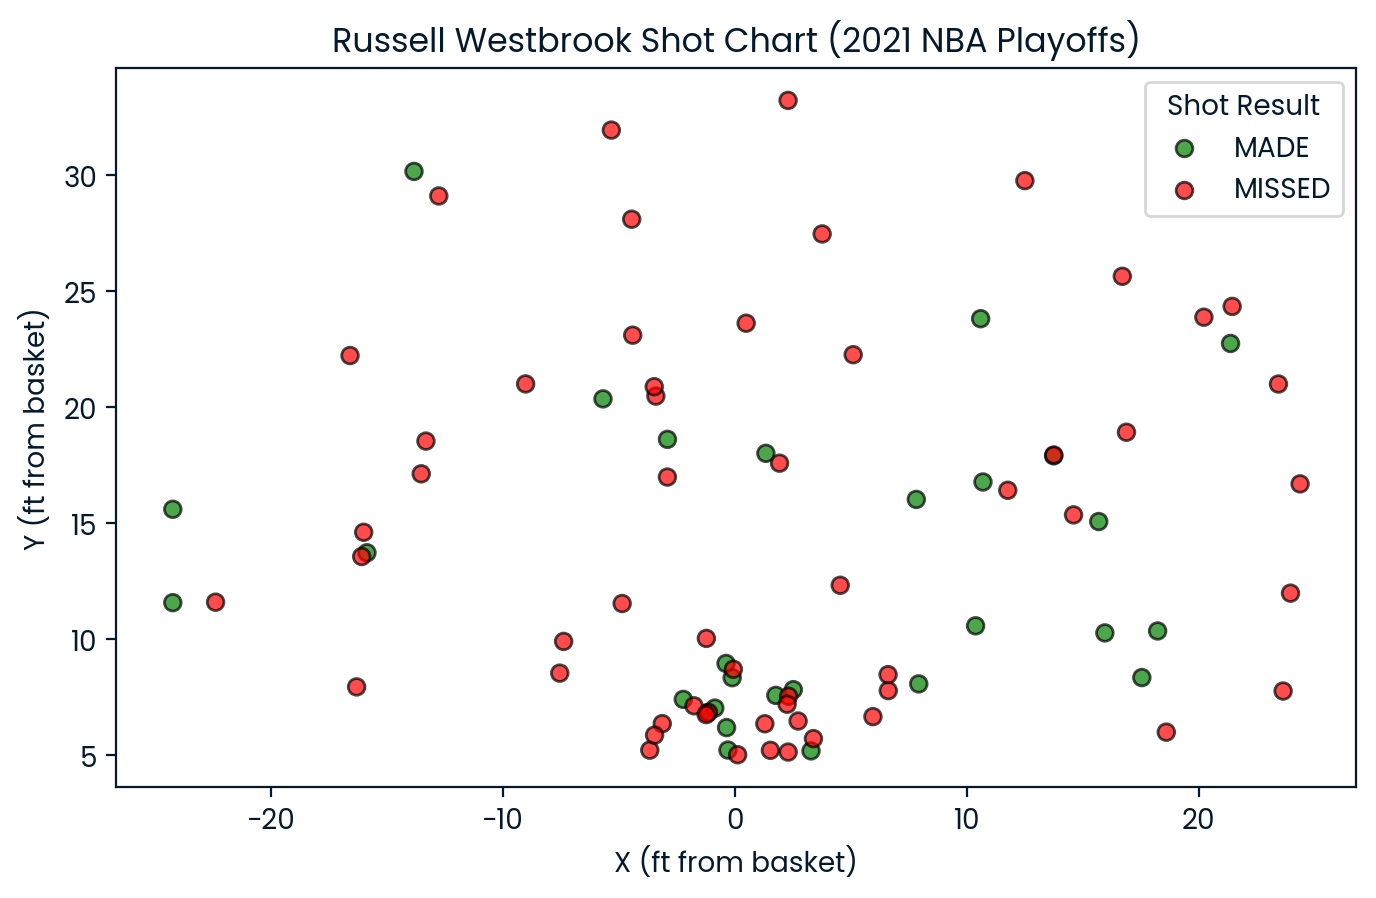

In [7]:
import matplotlib.pyplot as plt

# Filter data for Seth Curry
Russell_Westbrook_shots = nba[nba['SHOOTER'] == 'Russell Westbrook']

# Set color map for 'MADE' and 'MISSED'
color_map = {'MADE': 'green', 'MISSED': 'red'}
colors = Russell_Westbrook_shots['SCORE'].map(color_map)

plt.figure(figsize=(8, 7))
plt.scatter(Russell_Westbrook_shots['X'], Russell_Westbrook_shots['Y'], c=colors, alpha=0.7, edgecolor='k')

# Add legend
for score, color in color_map.items():
    plt.scatter([], [], c=color, label=score, alpha=0.7, edgecolor='k')
plt.legend(title='Shot Result')

plt.title("Russell Westbrook Shot Chart (2021 NBA Playoffs)")
plt.xlabel("X (ft from basket)")
plt.ylabel("Y (ft from basket)")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

The second set of visualizations consists of individual player shot charts, which break down the “range” component spatially for each player, showing where on the court they prefer to shoot and their success from those locations. Chris Paul demonstrates a heavy concentration of shots in the mid-range, particularly around the right elbow and free-throw line, with a balanced mix of makes (green) and misses (red). Trae Young exhibits a highly analytics-driven shot selection, with a large volume of attempts either directly at the rim (floaters and layups) or from deep three-point range, leaving very few shots in between. Russell Westbrook also has a high volume at the rim but takes a notable number of mid-range shots (right side), which appear less efficient as indicated by many red dots in the 10–20 foot range. Seth Curry shows a highly specialized pattern, taking almost exclusively three-pointers or shots at the rim, leaving the mid-range almost empty. Scatter plots were chosen for these visualizations because they are the only chart type that can map two quantitative variables, X and Y coordinates onto a two-dimensional plane, accurately representing the physical locations of shots on the court. Color encoding to distinguish shot results (made vs. missed) is critical: green indicates successful shots and red indicates misses, allowing the audience to instantly and intuitively differentiate outcomes. Using alternative visual encodings, such as shapes, would be less effective, as it would create additional visual clutter and reduce immediate interpretability.

## Avenue 3: Aggregated Efficiency by Player and Ranges

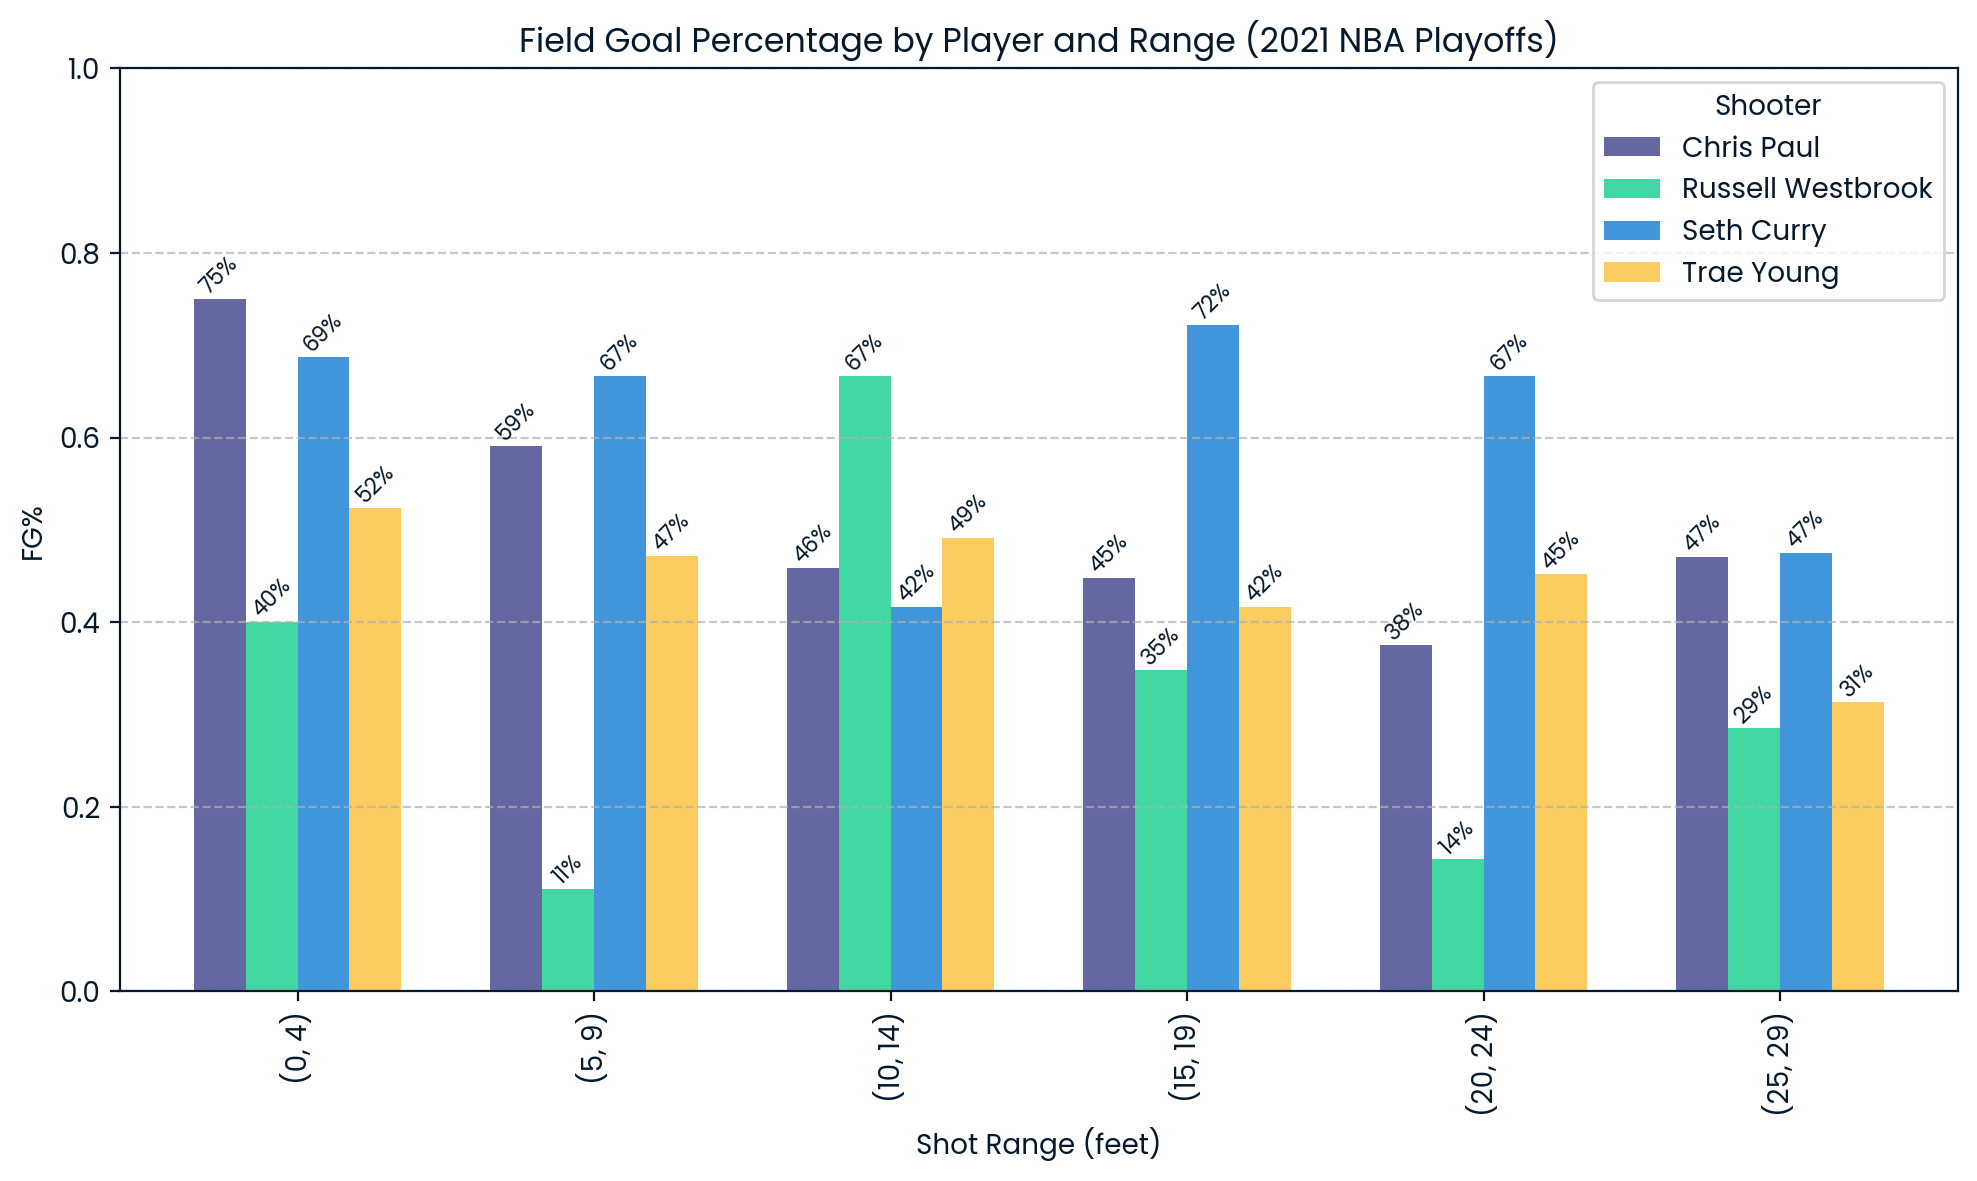

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Compute shooting percentage (FG%) by player and range ---
nba['MadeFlag'] = nba['SCORE'].apply(lambda x: 1 if x.upper() == 'MADE' else 0)

# Define the correct order of your range bins
range_order = ['(0, 4)', '(5, 9)', '(10, 14)', '(15, 19)', '(20, 24)', '(25, 29)']

# Convert RANGE column to an ordered categorical type
nba['RANGE'] = pd.Categorical(nba['RANGE'], categories=range_order, ordered=True)

# --- Group and compute FG% ---
fg_percent = nba.groupby(['SHOOTER', 'RANGE'])['MadeFlag'].mean().reset_index()

# --- Pivot data for easier plotting ---
fg_pivot = fg_percent.pivot(index='RANGE', columns='SHOOTER', values='MadeFlag')

# --- Plot ---
ax = fg_pivot.plot(kind='bar', figsize=(10,6), width=0.7)
plt.title('Field Goal Percentage by Player and Range (2021 NBA Playoffs)')
plt.ylabel('FG%')
plt.xlabel('Shot Range (feet)')
plt.ylim(0, 1)
plt.legend(title='Shooter')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show percentage labels on bars
for container in ax.containers:
    ax.bar_label(container, labels=[f'{v*100:.0f}%' for v in container.datavalues], fmt='%.0f%%',rotation=45, fontsize=8)

plt.tight_layout()
plt.show()


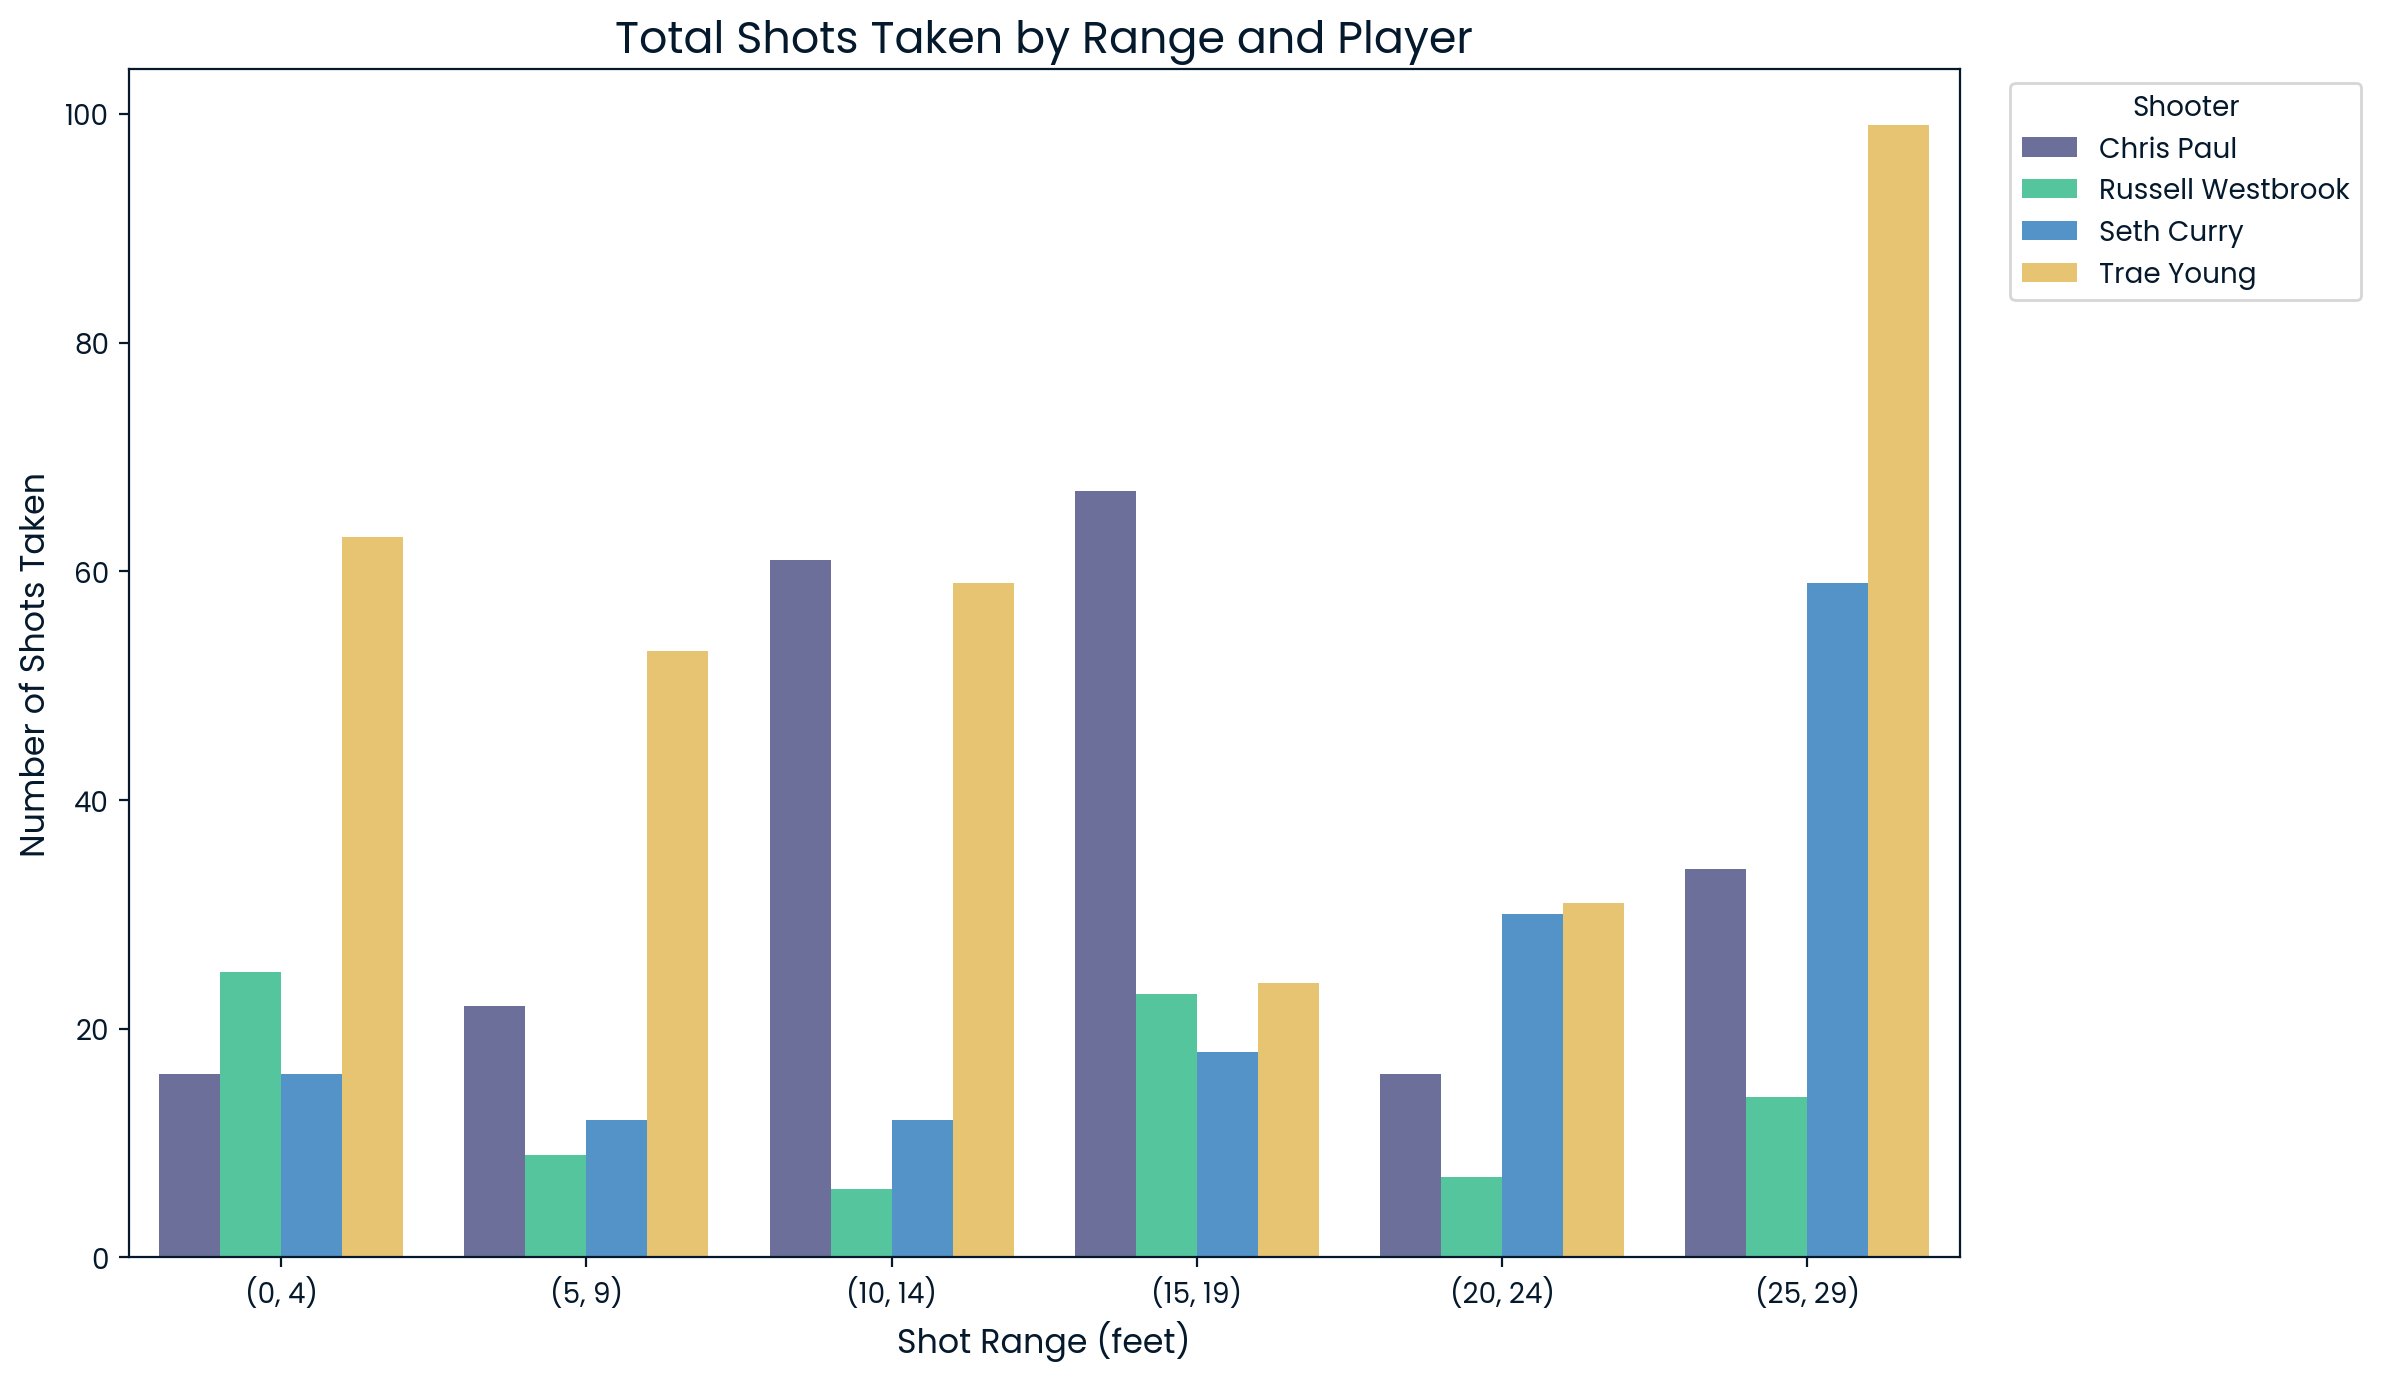

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Data Processing ---
# Group the data by both 'SHOOTER' and 'RANGE', then count the
# number of occurrences (shots) in each group using .size().
# .reset_index() converts the result back into a flat DataFrame
# and we name the new count column 'SHOT_COUNT'.
try:
    shot_counts = nba.groupby(['SHOOTER', 'RANGE']).size().reset_index(name='SHOT_COUNT')

    # --- 2. Visualization ---
    # We will create a grouped bar chart to show the counts.
    # 
    
    # Set the size of the plot
    plt.figure(figsize=(12, 7))

    # Create the grouped bar plot using seaborn
    # - x='RANGE' puts the shot range on the x-axis.
    # - y='SHOT_COUNT' sets the height of the bars based on our count.
    # - hue='SHOOTER' creates separate, colored bars for each player, grouped by range.
    sns.barplot(data=shot_counts, x='RANGE', y='SHOT_COUNT', hue='SHOOTER')

    # Add titles and labels for clarity
    plt.title('Total Shots Taken by Range and Player', fontsize=16)
    plt.xlabel('Shot Range (feet)', fontsize=12)
    plt.ylabel('Number of Shots Taken', fontsize=12)
    
    # Move the legend outside the plot area for better readability
    plt.legend(title='Shooter', bbox_to_anchor=(1.02, 1), loc='upper left')

    # Adjust layout to prevent labels from being cut off
    plt.tight_layout()

    # Display the plot
    plt.show()

except NameError:
    print("Error: The DataFrame 'nba' is not defined.")
    print("Please make sure your data is loaded into a DataFrame named 'nba'.")
except KeyError as e:
    print(f"Error: Missing expected column {e}.")
    print("Please ensure your DataFrame has 'SHOOTER' and 'RANGE' columns.")


Analysis: The purpose of the first bar graph is to display how a different range affects how probable the player is to make the shot. Chris Paul is most likely to score from the 0 to 4 feet range and least likely to score from the 20 to 24 feet range. Russell Westbrook is most likely to score from the 10 to 14 feet range and least likely to score from the 5 to 9 feet range. Seth Curry is most likely to score from the 15 to 19 feet range and least likely to score from the 25 to 29 feet range. Trae Young is most likely to score from the 0 to 4 feet range and least likely to score from the 25 to 29 feet range. There are limitations to this bar graph as it doesn't display the amount of shots taken by each player from that range, only the percentages. This is important as it doesn't reveal all of the context behind why some percentage might be lower or higher than what they should actually be since a smaller sample size are more likely to have a skewed result compared to larger sample sizes. This is the part of the purpose of the second bar graph, to provide context to the percentages in the first graph. The main purpose is to reveals whether the players were taking the most shots from the ranges they were most efficient from. Chris Paul took the most shots from the 15 to 19 feet range, even though he was most efficient from the 0 to 4 feet range. Russell Westbrook took the most shots from the 0 to 4 feet range, even though he's most likely to score from the 10 to 14 feet range. Seth Curry took the most shots from the the 25-29 feet range, even though he's most likely to score from the 15 to 19 feet range. Trae Young took the most shots from the the 25-29 feet range, even though he's most likely to score from the 0 to 4 feet range. None of them took the most shots from the range they were most efficient. A bar graph was used because it makes comparisons of quantitative data between different values of the same category intuitive to understand. In this case, the quantitative data we are comparing are field goal percentages and total shots taken.

## Avenue 4: Shot Outcome Probability vs. Distance

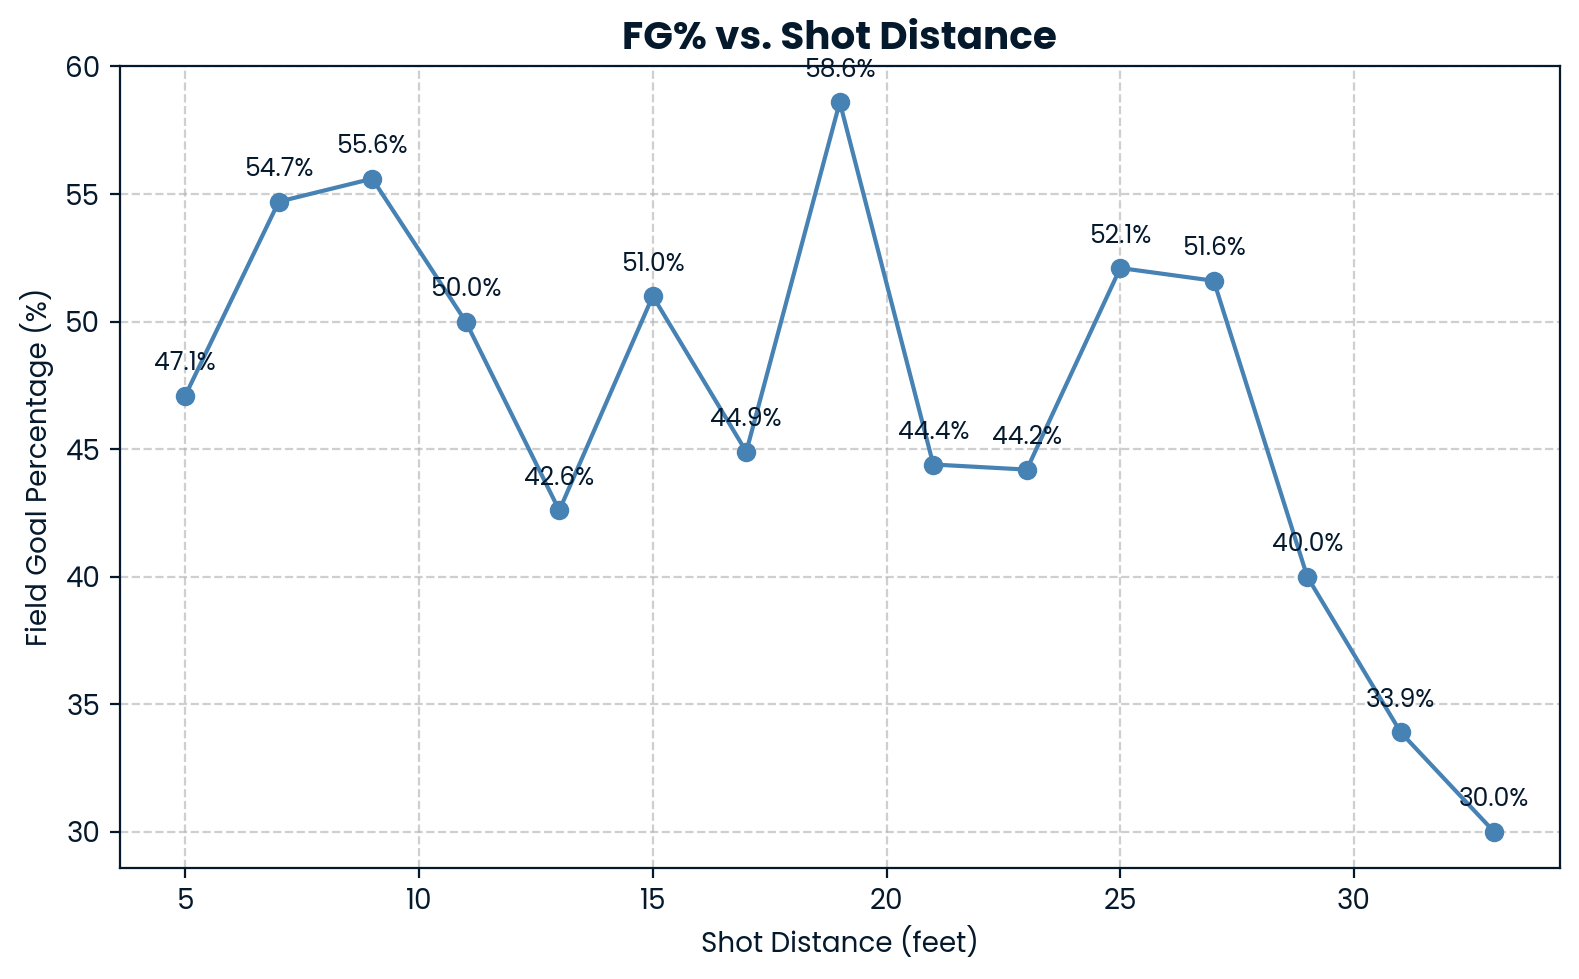

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Load Data ---
try:
    nba = pd.read_csv("nba_players_shooting.csv", index_col=0)
except FileNotFoundError:
    print("Error: 'nba_players_shooting.csv' not found.")
    exit()

# Convert MADE/MISSED to numerical flag
nba['MadeFlag'] = nba['SCORE'].apply(lambda x: 1 if x.upper() == 'MADE' else 0)

# --- 2. Compute Shot Distance ---
nba['Distance'] = np.sqrt(nba['X']**2 + nba['Y']**2)

# --- 3. Bin distances (e.g., every 2 feet) ---
bin_edges = np.arange(0, nba['Distance'].max() + 2, 2)  # 0,2,4,...
nba['DistanceBin'] = pd.cut(nba['Distance'], bins=bin_edges)

# --- 4. Compute mean FG% per distance bin ---
fg_by_distance = nba.groupby('DistanceBin').agg(
    Mean_FG=('MadeFlag', 'mean'),
    Attempts=('MadeFlag', 'count')
).reset_index()
fg_by_distance['Mean_FG_Display'] = (fg_by_distance['Mean_FG'] * 100).round(1)

# --- 5. Plot FG% vs Distance ---
plt.figure(figsize=(8,5))
plt.plot(
    [interval.mid for interval in fg_by_distance['DistanceBin']],
    fg_by_distance['Mean_FG_Display'],
    marker='o', linestyle='-', color='steelblue'
)
plt.title("FG% vs. Shot Distance", fontsize=14, fontweight='bold')
plt.xlabel("Shot Distance (feet)")
plt.ylabel("Field Goal Percentage (%)")
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate each point with FG%
for x, y in zip([interval.mid for interval in fg_by_distance['DistanceBin']], fg_by_distance['Mean_FG_Display']):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


The fourth visualization examines field goal percentage as a function of shot distance, transitioning from the discrete “ranges” used in the first visualization to a continuous view that captures the impact of distance on shooting efficiency. The plot displays aggregate FG% at one-foot increments, revealing that overall efficiency decreases as distance increases. Notable patterns emerge, including a significant dip at 12 feet (42.6%), corresponding to the notoriously inefficient “long-two” area, and a peak at 19 feet (58.6%), likely influenced by a high-volume mid-range shooter in the dataset, such as Chris Paul, who is particularly effective from that spot. A sharp drop-off beyond 27 feet from 40.0% to 30.0% reflects the difficulty of very deep three-point shots. A line graph was chosen for this visualization because it effectively displays the relationship between two quantitative variables (shot distance and FG%), connecting points to highlight trends, peaks, and valleys in efficiency. A limitation of this visualization is that it aggregates all four players, so the 19-foot peak is likely driven by one specialist (Chris Paul) and may not be representative of the other players. This could be improved by faceting the plot into four smaller line graphs, one for each player, to observe whether their individual distance-efficiency curves differ.

## Avenue 5: FG% vs. Defenders

[Source](https://www.nba.com/stats/players/shooting/?Season=2020-21&SeasonType=Playoffs&PerMode=Totals) of dataset.

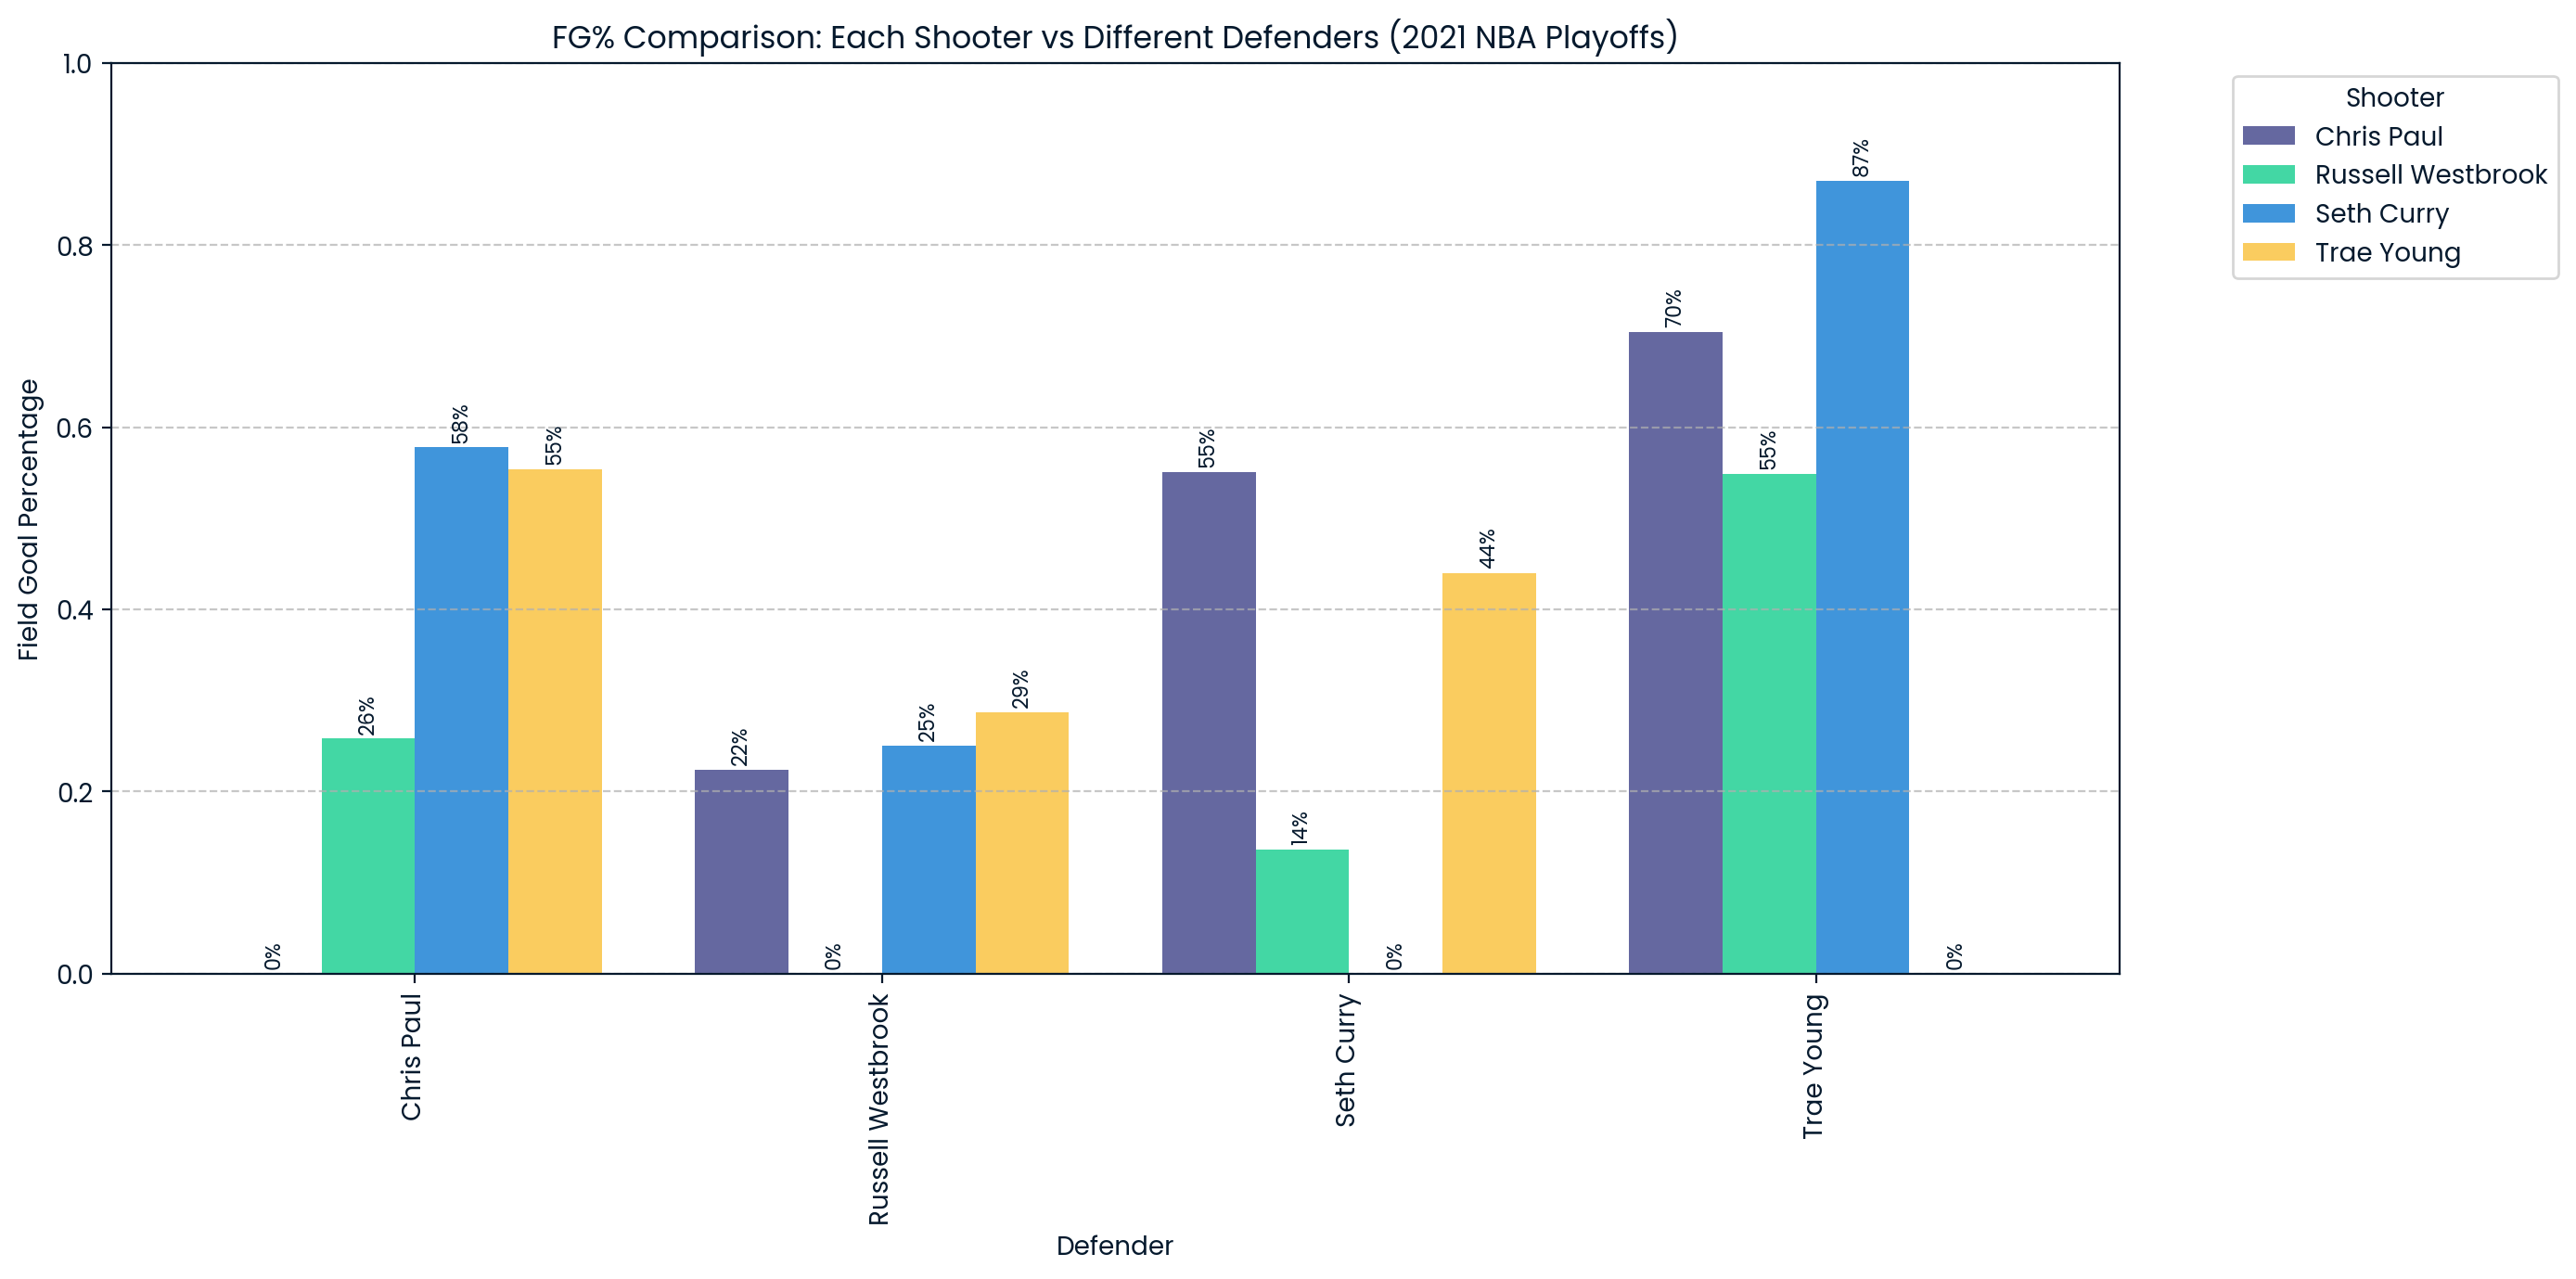

In [11]:
# --- Compute FG% by shooter and defender using 'Defender' column ---
# Create a new DataFrame to avoid modifying the original nba DataFrame
nba_shooter_defender = nba.copy()

# Group by shooter and defender, calculate FG%
fg_by_defender = nba_shooter_defender.groupby(['SHOOTER', 'DEFENDER'])['MadeFlag'].mean().reset_index()

# Pivot for grouped bar plot: rows=Defender, columns=Shooter, values=FG%
fg_by_defender_pivot = fg_by_defender.pivot(index='DEFENDER', columns='SHOOTER', values='MadeFlag')

# --- Plot grouped bar chart to compare shooters against defenders ---
fig, ax = plt.subplots(figsize=(14, 7))

fg_by_defender_pivot.plot(kind='bar', ax=ax, width=0.8)
plt.title('FG% Comparison: Each Shooter vs Different Defenders (2021 NBA Playoffs)')
plt.ylabel('Field Goal Percentage')
plt.xlabel('Defender')
plt.ylim(0, 1)
plt.legend(title='Shooter', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with FG% values
for container in ax.containers:
    ax.bar_label(container, labels=[f'{v*100:.0f}%' if not pd.isna(v) else '' for v in container.datavalues], fontsize=8, rotation=90, padding=2)

plt.tight_layout()
plt.show()

The fifth visualization provides a comprehensive comparison of field goal percentage by combining both key variables: shooters and defenders. In this grouped bar chart, the X-axis represents the defender, and the colored bars within each group show how each of the four shooters performed against that specific defender. The chart shows that Chris Paul performs worst against Russell Westbrook, scoring only 25% of his shots compared to 55–58% against other defenders. Russell Westbrook struggles across most matchups, while Seth Curry performs well except against Westbrook, where his success rate drops to 14%. Trae Young consistently maintains high efficiency across defenders, with FG% values between 55% and 87%. The grouped bar chart was chosen because it allows comparison across two categorical variables (Shooter and Defender), and color encoding distinguishes shooters clearly via the legend. A noted limitation is that percentages do not account for shot volume, which could misrepresent performance if sample sizes are small. Therefore, for future analyses, confidence intervals could be added or include shot counts for greater accuracy. The analysis is limited to data from only four players during a single playoff run, so conclusions like “Trae Young is a poor defender” would apply only within this small sample and cannot be generalized to the entire league. Future work could integrate all three variables: shooter, range, and defender to examine how a player’s FG% from different ranges changes depending on the defender, using a heatmap or faceted bar charts to reveal more detailed patterns.

# 3.1 Logistic Regression with Resampling


-------------------
Predictive Accuracy
-------------------
Test Accuracy: 0.6538461538461539
Test ROC AUC: 0.7276785714285714

-------------------
10-Fold Cross-Validation
-------------------
Mean CV ROC AUC: 0.705099181062824
Std CV ROC AUC: 0.06623950705499634

-------------------
Bootstrap Coefficient CIs
-------------------
                       feature  coef_mean  ci_lower  ci_upper
0                            X   0.142133 -0.026357  0.324198
1                            Y  -0.151848 -0.375644  0.064652
2    SHOOTER_Russell Westbrook  -0.949166 -1.515689 -0.354459
3           SHOOTER_Seth Curry   0.545558  0.037795  1.087511
4           SHOOTER_Trae Young   0.171821 -0.277760  0.618615
5   DEFENDER_Russell Westbrook  -1.208947 -1.662755 -0.772893
6          DEFENDER_Seth Curry  -0.296979 -0.759620  0.147967
7          DEFENDER_Trae Young   1.010918  0.509351  1.548769
8               RANGE_(10, 14)  -0.174619 -0.651456  0.328545
9               RANGE_(15, 19)  -0.048104 -0.597

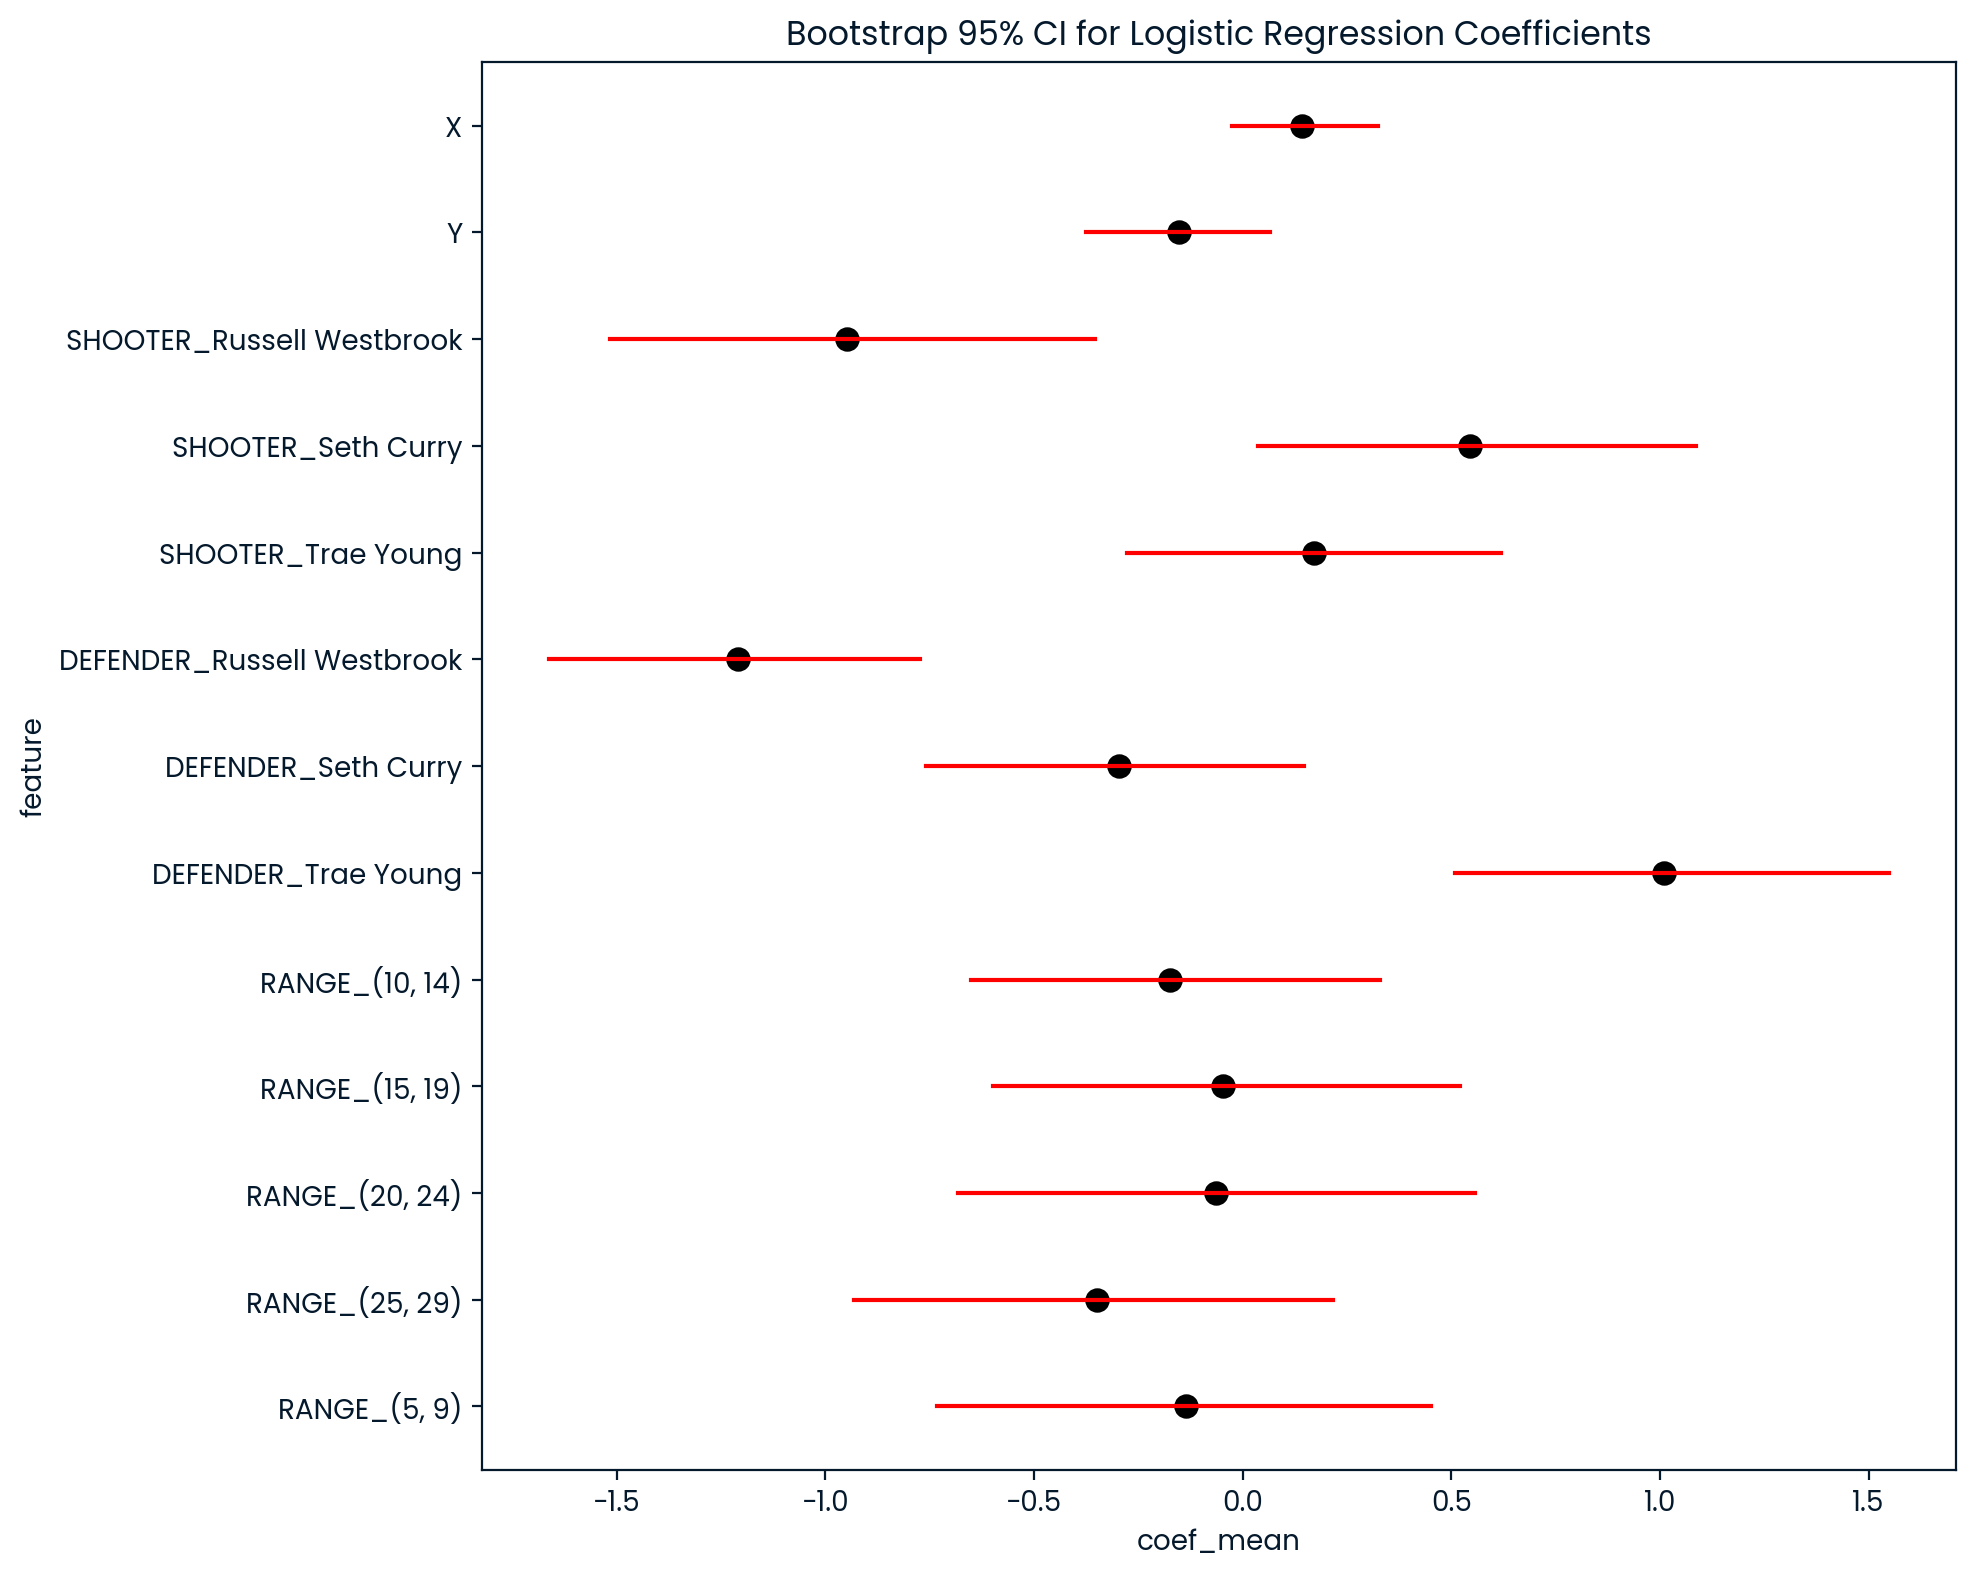

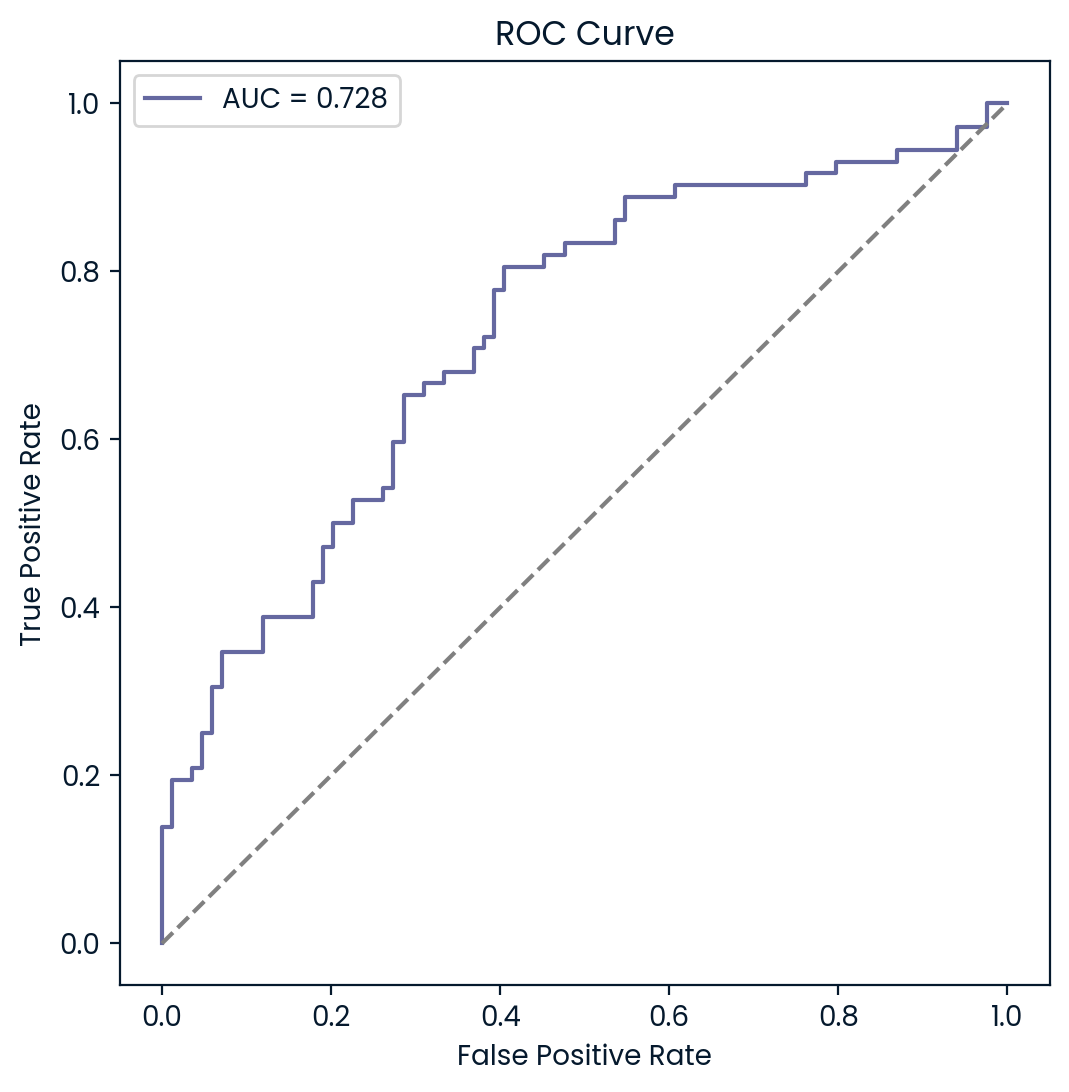

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("nba_players_shooting.csv")

# -----------------------------------------------------------
# 2. Feature-Specific Handling of Missingness
# -----------------------------------------------------------

# X,Y (numeric):
# → impute missing coords with column median
df["X"] = df["X"].fillna(df["X"].median())
df["Y"] = df["Y"].fillna(df["Y"].median())

# Categorical vars:
# SHOOTER, DEFENDER, RANGE
# → impute missing values with "Unknown"
categorical_cols = ["SHOOTER", "DEFENDER", "RANGE"]
for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")

# Target: SCORE
# Convert to 0/1
df["shot_made"] = df["SCORE"].map({"MADE": 1, "MISSED": 0})
# If SCORE is missing, drop those (only feature allowed to drop)
df = df.dropna(subset=["shot_made"])

# -----------------------------------------------------------
# 3. Build Predictors (after cleaning)
# -----------------------------------------------------------
numeric_cols = ["X", "Y"]

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

X = df[[c for c in df.columns if c not in ["INDEX", "SCORE", "shot_made"]]]
y = df["shot_made"]

# -----------------------------------------------------------
# 4. Train/Test Split
# -----------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------------------------------------
# 5. Standardize numeric columns only
# -----------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# -----------------------------------------------------------
# 6. Fit Logistic Regression
# -----------------------------------------------------------
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

print("\n-------------------")
print("Predictive Accuracy")
print("-------------------")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_prob))

# 7. 10-Fold Cross-Validation (Performance Evaluation)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

cv_auc = cross_val_score(
    log_reg,
    pd.concat([X_train_scaled, X_test_scaled]),
    pd.concat([y_train, y_test]),
    cv=kf,
    scoring="roc_auc"
)

print("\n-------------------")
print("10-Fold Cross-Validation")
print("-------------------")
print("Mean CV ROC AUC:", cv_auc.mean())
print("Std CV ROC AUC:", cv_auc.std())

# -----------------------------------------------------------
# 8. Bootstrap CI for Coefficients
# -----------------------------------------------------------
n_boot = 3000
coefs = []

for _ in range(n_boot):
    idx = np.random.choice(len(X_train_scaled), size=len(X_train_scaled), replace=True)
    X_b = X_train_scaled.iloc[idx]
    y_b = y_train.iloc[idx]

    model_b = LogisticRegression(max_iter=500)
    model_b.fit(X_b, y_b)
    coefs.append(model_b.coef_[0])

coefs = np.array(coefs)
coef_means = coefs.mean(axis=0)
coef_lower = np.percentile(coefs, 2.5, axis=0)
coef_upper = np.percentile(coefs, 97.5, axis=0)

results = pd.DataFrame({
    "feature": X.columns,
    "coef_mean": coef_means,
    "ci_lower": coef_lower,
    "ci_upper": coef_upper
})

print("\n-------------------")
print("Bootstrap Coefficient CIs")
print("-------------------")
print(results)

# -----------------------------------------------------------
# 9. Plot Bootstrap Confidence Intervals
# -----------------------------------------------------------
plt.figure(figsize=(10, 8))
sns.pointplot(data=results, x="coef_mean", y="feature", join=False, color="black")

for i in range(len(results)):
    plt.plot([results.ci_lower[i], results.ci_upper[i]], [i, i], 'r-')

plt.title("Bootstrap 95% CI for Logistic Regression Coefficients")
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 10. Plot ROC Curve
# -----------------------------------------------------------
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# Bootstrap: 
Bootstrap resampling provides an empirical way to estimate the uncertainty in model parameters by repeatedly fitting the model to many resampled versions of the training data. In this analysis, 3,000 bootstrap iterations were used to generate a distribution for each logistic regression coefficient, allowing for the calculation of robust 95% confidence intervals. This approach is especially valuable for smaller or specialized datasets, such as the playoff-only shot attempts in this study, because it does not rely on assumptions of normality or large-sample theory. The bootstrap results revealed that defender indicators exhibited tightly clustered coefficient distributions that did not cross zero, indicating strong and stable associations with shot outcomes. In contrast, the location variables (X, Y) and the categorical RANGE variable produced wide, zero-crossing intervals, showing that their estimated effects were unstable and likely influenced by collinearity or insufficient independent variation.

# Cross-Validation:
Cross-validation was used to assess how well the logistic regression model generalizes beyond a single train/test split. A 10-fold K-Fold procedure repeatedly divided the data into training and validation subsets to evaluate model performance across multiple partitions. This method helps reduce the sensitivity of results to any particular split, making it especially helpful for moderately sized datasets where performance estimates can otherwise be noisy. The cross-validated ROC AUC closely matched the test-set AUC of about 0.73, indicating that the model’s predictive ability is consistent across different folds and that no major overfitting is present. The relatively low variability across folds suggests that the relationship between predictors and shot outcomes is stable enough that the model behaves predictably across different subsets of the data.

# Logistic Regression: 
Our logistic regression shows moderate discrimination of made vs missed shots (AUC = 0.728), suggesting meaningful signal in this playoff-only, four-player dataset. In this model specification, defender indicators appear more stable than distance/location terms. Bootstrap confidence intervals support a clear defender association: shots guarded by Russell Westbrook show a strong negative effect (Coef = -1.21), corresponding to roughly 70% lower odds of a make relative to the baseline defender, while shots guarded by Trae Young show a strong positive effect (Coef = +1.01), corresponding to approximately 2.7–3× higher odds of a make. Shooter effects also emerge, with Seth Curry showing a reliably positive coefficient (= +0.55) and Russell Westbrook showing a reliably negative coefficient (= -0.95) relative to the baseline shooter. In contrast, X, Y, and RANGE were not statistically stable in this specification, which may reflect feature overlap from including both continuous location measures and discretized distance bands simultaneously.


# 3.2 K-Means Clustering

Preview of data:
      SHOOTER         X         Y   RANGE    DEFENDER SCORE
0  Seth Curry -3.808987  5.583621  (0, 4)  Chris Paul  MADE
1  Seth Curry -0.104279  5.919138  (0, 4)  Trae Young  MADE
2  Seth Curry -0.525864  8.912239  (0, 4)  Trae Young  MADE
3  Seth Curry -0.790616  7.503782  (0, 4)  Chris Paul  MADE
4  Seth Curry  2.119074  5.320534  (0, 4)  Trae Young  MADE

Total rows after cleaning: 776


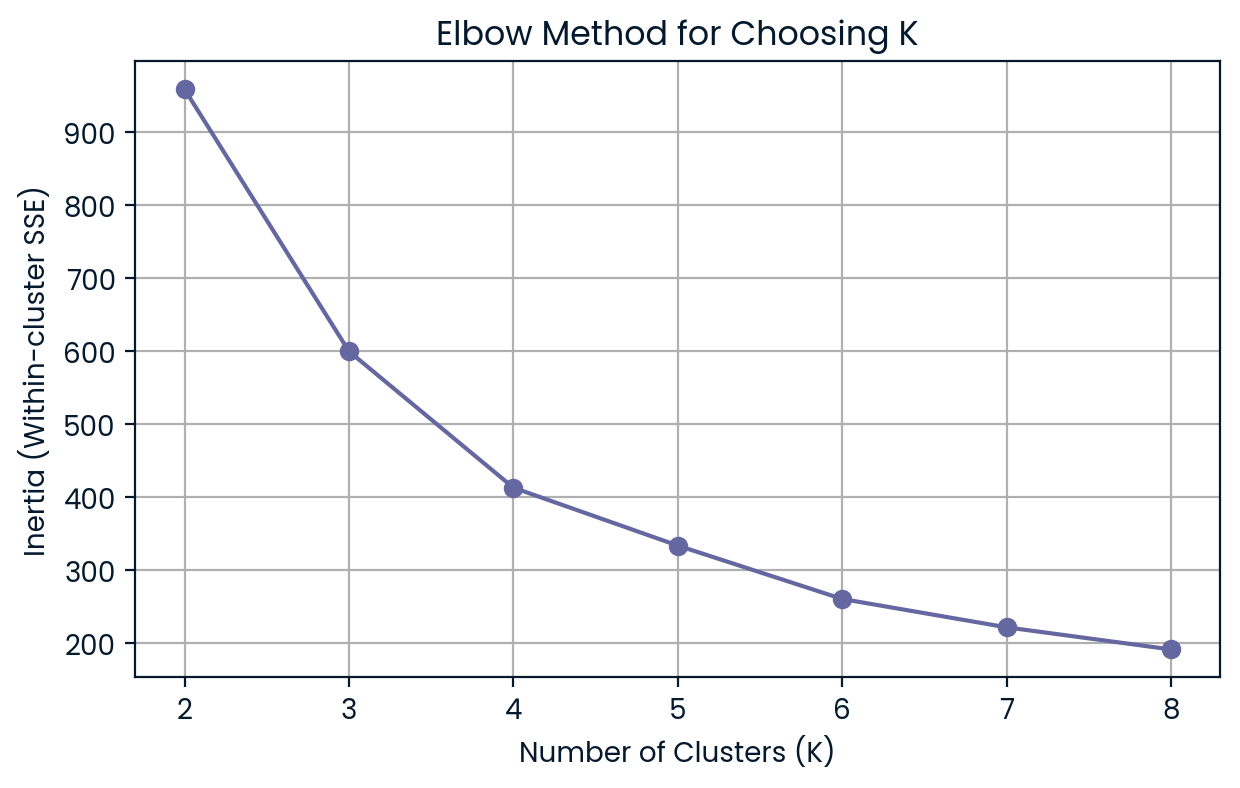


Cluster labels assigned. Unique clusters: [0 2 3 1]


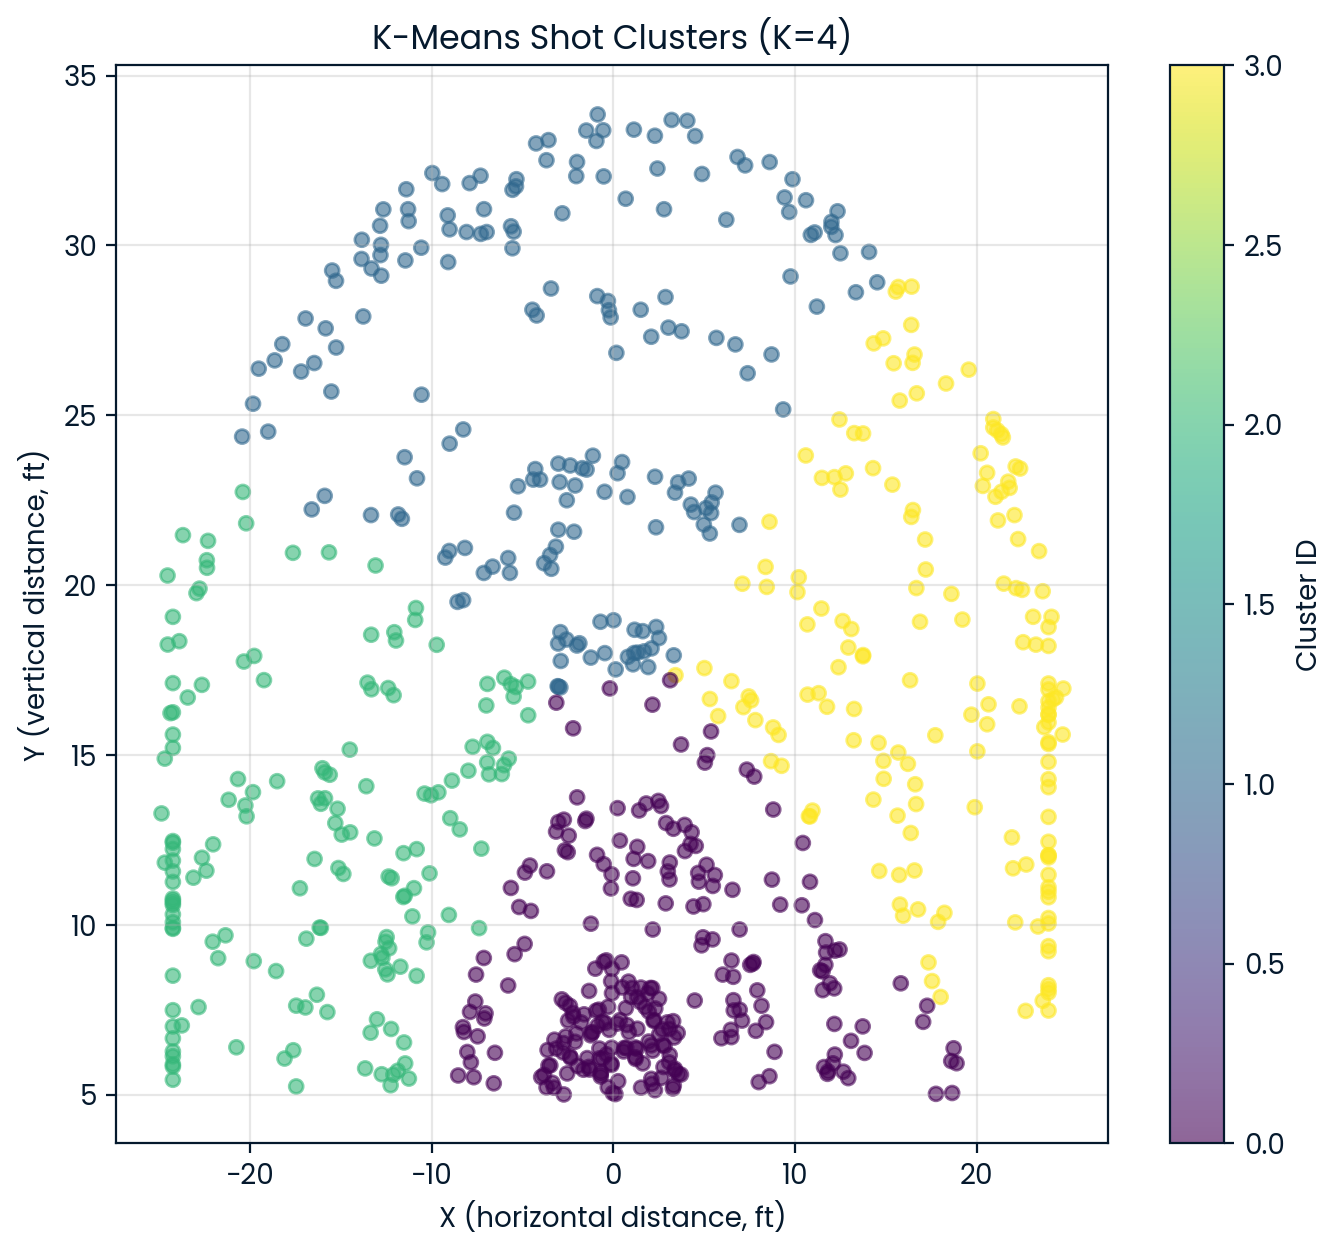


FG% and shot attempts by cluster:
   cluster  shot_attempts  fg_pct
0        0            262   0.527
1        1            185   0.400
2        2            164   0.415
3        3            165   0.485


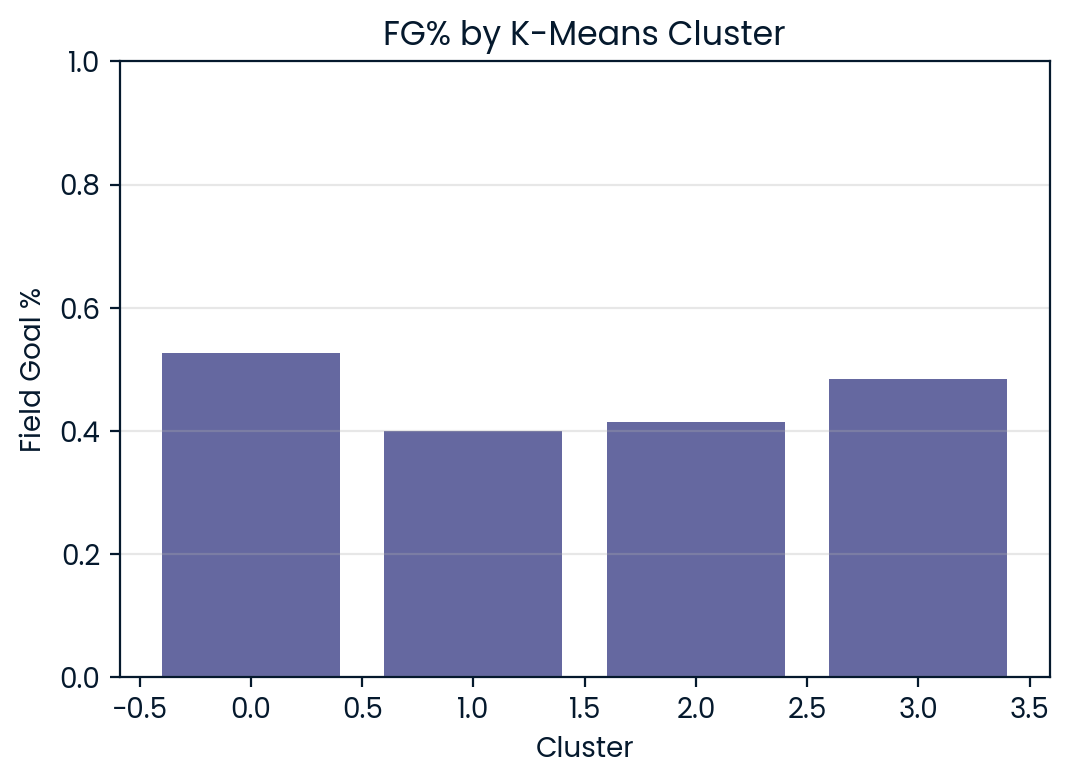


Player-level cluster summary (first 20 rows):
              SHOOTER  cluster  shot_attempts  fg_pct
0          Chris Paul        0             61   0.607
1          Chris Paul        1             61   0.459
2          Chris Paul        2             52   0.365
3          Chris Paul        3             42   0.500
4   Russell Westbrook        0             35   0.343
5   Russell Westbrook        1             19   0.211
6   Russell Westbrook        2             10   0.300
7   Russell Westbrook        3             20   0.450
8          Seth Curry        0             34   0.647
9          Seth Curry        1             44   0.432
10         Seth Curry        2             29   0.586
11         Seth Curry        3             40   0.675
12         Trae Young        0            132   0.508
13         Trae Young        1             61   0.377
14         Trae Young        2             73   0.397
15         Trae Young        3             63   0.365

Cluster stats for Seth Curry:
    

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


df = pd.read_csv("nba_players_shooting.csv")

# Binary outcome for convenience
df['is_made'] = (df['SCORE'] == 'MADE').astype(int)

# Drop rows with missing coordinates if any
df = df.dropna(subset=['X', 'Y']).reset_index(drop=True)

print("Preview of data:")
print(df[['SHOOTER', 'X', 'Y', 'RANGE', 'DEFENDER', 'SCORE']].head())
print("\nTotal rows after cleaning:", len(df))

# 2. Prepare features and scale (X, Y only)
shot_xy = df[['X', 'Y']].copy()

scaler = StandardScaler()
shot_xy_scaled = scaler.fit_transform(shot_xy)

# 3. Elbow method to choose K
inertia = []
K_values = range(2, 9)  

for k in K_values:
    kmeans_temp = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans_temp.fit(shot_xy_scaled)
    inertia.append(kmeans_temp.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(K_values, inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-cluster SSE)")
plt.title("Elbow Method for Choosing K")
plt.grid(True)
plt.show()

K = 4 

kmeans = KMeans(n_clusters=K, random_state=0, n_init=10)
df['cluster'] = kmeans.fit_predict(shot_xy_scaled)

print("\nCluster labels assigned. Unique clusters:", df['cluster'].unique())


# 5. Visualize clusters on the court
plt.figure(figsize=(8, 7))
scatter = plt.scatter(df['X'], df['Y'], c=df['cluster'],
                      cmap='viridis', alpha=0.6, s=25)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("X (horizontal distance, ft)")
plt.ylabel("Y (vertical distance, ft)")
plt.title(f"K-Means Shot Clusters (K={K})")
plt.grid(True, alpha=0.3)
plt.show()

# 6. FG% and volume by cluster
cluster_summary = df.groupby('cluster')['is_made'].agg(
    shot_attempts='count',
    fg_pct='mean'
).reset_index()

cluster_summary['fg_pct'] = cluster_summary['fg_pct'].round(3)

print("\nFG% and shot attempts by cluster:")
print(cluster_summary)

plt.figure(figsize=(6, 4))
plt.bar(cluster_summary['cluster'], cluster_summary['fg_pct'])
plt.xlabel("Cluster")
plt.ylabel("Field Goal %")
plt.title("FG% by K-Means Cluster")
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.show()


player_cluster = (
    df.groupby(['SHOOTER', 'cluster'])['is_made']
      .agg(shot_attempts='count', fg_pct='mean')
      .reset_index()
)

player_cluster['fg_pct'] = player_cluster['fg_pct'].round(3)

print("\nPlayer-level cluster summary (first 20 rows):")
print(player_cluster.head(20))

# Seth Curry distribution by cluster
example_player = "Seth Curry"  # change to any name in SHOOTER column
print(f"\nCluster stats for {example_player}:")
print(player_cluster[player_cluster['SHOOTER'] == example_player])


# **1. Purpose of Applying K-Means Clustering**

We used K-Means clustering as an unsupervised learning method to uncover natural spatial groupings of shot locations based solely on X and Y court coordinates. Unlike supervised models that require labeled outcomes, K-Means enables the data to reveal underlying shooting zones without prior assumptions about where these zones should exist. Because our research question focuses on understanding how spatial positioning influences shot success, clustering serves as a foundational method to identify meaningful areas of the court where shooting efficiency systematically differs. This allows us to translate continuous shot-coordinate data into interpretable, actionable spatial regions that can be compared across players, defenders, and outcomes.

---

# **2. How the K-Means Procedure Was Implemented**

The K-Means implementation began by applying the algorithm to all shot coordinates for the four high-usage guards in the dataset. We experimented with values of K ranging from 2 to 8 and used the Elbow Method to determine the optimal number of clusters by examining the decline in inertia. The sharp reduction in inertia from approximately 950 (K=2) to 600 (K=3) and then to 410 (K=4) indicated diminishing returns beyond four clusters. Therefore, K = 4 was selected as the most appropriate configuration. Each shot was assigned to one of the four clusters, representing distinct shot zones that emerge from the geometry of the court. These clusters were then used to compute both overall and player-specific field goal percentages, allowing us to compare shooting efficiency across spatial regions.

---

# **3. Interpretation of Spatial Cluster Structure**

The resulting clusters corresponded to intuitive and recognizable regions of the half court. Visual inspection of the scatter plot revealed that Cluster 0 captured shots near the basket and inside the short midrange area, which tend to be high-efficiency regions in NBA play. Clusters 1 and 2 represented increasingly distant perimeter or deep midrange zones, while Cluster 3 consisted of extended midrange or floater-range shots located slightly farther from the basket but not as distant as typical perimeter shots. These spatial patterns emerged solely from the algorithm and reflect the organic shot tendencies of the players studied. Because these clusters align with well-established basketball shot zones, the output demonstrates that K-Means successfully captured meaningful structure within the shooting data, enabling quantitative comparisons between distinct areas of the court.

---

# **4. Insights Derived from the Clustering Output**

The cluster-level statistics provide clear evidence that shot location meaningfully affects shooting success. Field goal percentage varied substantially across clusters, with Cluster 0 producing the highest FG% at 52.7%, reflecting its close-proximity shot profile. In contrast, Cluster 1 had the lowest FG% at 40.0%, consistent with longer-distance attempts. Clusters 2 and 3 produced FG% of 41.5% and 48.5%, respectively, demonstrating intermediate efficiency levels that align with their spatial placement. These differences are not trivial—there is a 12.7 percentage point gap between the most efficient and least efficient zones, reinforcing that spatial positioning is a major factor in shot success.

Player-specific breakdowns deepen these insights. For example, Seth Curry shot 67.5% in Cluster 3 and 64.7% in Cluster 0, but only 43.2% in Cluster 1, highlighting dramatic differences in personal efficiency across locations. This indicates that even elite shooters experience large declines in performance when forced into less favorable zones. These empirical findings validate the importance of spatial positioning in shaping shot outcomes and provide a data-driven basis for tailoring player-specific offensive strategies.

---

# **5. How K-Means Clustering Addresses our Problem Statement**

K-Means clustering directly addresses the spatial component by transforming raw shot coordinates into interpretable shot zones with quantifiable performance differences. Because FG% varies widely between clusters—ranging from 40% to 52.7% overall, and even more dramatically for individual players—the results clearly demonstrate that spatial positioning alone is a significant predictor of shot success. These findings can be connected to defensive matchup effects as well. If certain defenders consistently push shooters into low-efficiency clusters, this would provide strong evidence that defensive pressure meaningfully affects shot outcomes.

Furthermore, clustering enables comparisons across players, revealing how individual shot profiles interact with defensive pressure. The fact that Seth Curry performs exceptionally well in certain clusters but poorly in others suggests that defenders who can influence the spatial distribution of his shots could meaningfully alter his efficiency. Thus, K-Means not only identifies where shots occur but also provides a framework for understanding how defensive behavior and court geometry jointly influence offensive performance. This makes clustering a crucial part of our analysis, complementing logistic regression and resampling-based inference to give a comprehensive answer to the research question.


# Final Interpretation and Summary

The results of our analysis provide a clear understanding of how defensive matchups and spatial positioning influence shot success during the 2021 NBA Playoffs. Across all methods: K-Means clustering, logistic regression, and resampling. We observe consistent evidence that both where a shot is taken and who is involved meaningfully determine the likelihood of scoring.

The clustering analysis revealed that the court naturally divides into shot zones with distinctly different efficiencies. Shots taken in our most efficient cluster averaged 52.7%, compared to just 40.0% in the least efficient cluster, demonstrating that shot location alone produces large changes in scoring probability. This pattern held even for elite shooters like Seth Curry, whose efficiency ranged from 43% to nearly 68% depending on the cluster, showing that players benefit substantially from being in their preferred spatial zones.

Our logistic regression model strengthened these findings by quantifying how both shooters and defenders influence outcomes. Certain defenders such as Russell Westbrook significantly reduced shot success, while others increased it, and these effects remained stable when evaluated using bootstrap confidence intervals. The model achieved ROC AUC values around 0.70–0.73, indicating that spatial and matchup variables together provide reliable predictive signal for shot outcomes across the playoff sample.

These results show that playoff shot success is not random but systematically shaped by identifiable patterns in both defender pressure and shooting location. The magnitude of the effects observed double digit efficiency swings between shot zones and notable defender-specific impacts suggests clear strategic implications: teams can meaningfully influence outcomes by steering players toward their most efficient regions while avoiding defensive matchups and court areas associated with lower success.

Contributions:
Abhidev: Set up dockerfile, coding K-mean clusering and analysis/interpretation
Allen: Coding bootstrap and logistic regression, wrote final report sections for logistic regression, and made final presentation slides
Tung: Writing report for components 1,2,3 and bootstrap and logistic regression interpretation/analysis